# 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 파인튜닝 모델 종합 성능 비교 분석

이 노트북은 원본 HyperCLOVAX 모델, KoBART 원본 모델과 다양한 파라미터로 미세조정된 모델들의 성능을 종합적으로 비교하여 난독화된 한국어 문자열을 원본으로 복원하는 성능을 분석합니다.

## 분석 목표
- 모든 모델의 정량적 성능 비교 (BLEU, ROUGE, 문자 정확도)
- 학습량(데이터셋 크기) 차이에 따른 난독화 해제 성능 비교
- 학습률(Learning Rate) 차이에 따른 난독화 해제 성능 비교
- 배치 크기(Batch Size) 차이에 따른 난독화 해제 성능 비교
- 원본 모델 vs 파인튜닝 모델 성능 비교
- 정성적 분석 (실제 출력 예시 비교)
- 카테고리별 성능 분석
- 추론 시간 및 효율성 비교
- 파인튜닝 효과 종합 분석
- 결과 시각화
- **성능 결과 CSV 파일 추출**

## 비교 모델 정보
- **팀명**: 91veMe4Plus
- **원본 모델들**:
  - HyperCLOVAX 원본: `naver-hyperclovax/HyperCLOVAX-SEED-Text-Instruct-0.5B`
  - gogamza KoBART 원본: `gogamza/kobart-base-v2`
  - hyunwoongko KoBART 원본: `hyunwoongko/kobart` (hyunwoongko KoBART 계열의 베이스 모델)
- **HyperCLOVAX-0.5B 기반 파인튜닝 모델들**:
  - **학습량 차이 파인튜닝 모델** (HyperCLOVAX-0.5B 기반):
    - 10K 데이터셋 모델: `hyperclova-deobfuscation-lora-with-10k-datasets`
    - 30K 데이터셋 모델: `hyperclova-deobfuscation-lora-with-30k-datasets`
  - **학습률 차이 파인튜닝 모델** (HyperCLOVAX-0.5B 기반):
    - 1e-4 Learning Rate 모델: `hyperclova-deobfuscation-lora-1e-4-learning-rate`
    - 5e-4 Learning Rate 모델: `hyperclova-deobfuscation-lora-5e-4-learning-rate`
  - **배치 크기 차이 파인튜닝 모델** (HyperCLOVAX-0.5B 기반):
    - Batch Size 1 모델: `hyperclova-deobfuscation-lora-with-1-batch-size`
    - Batch Size 2 모델: `hyperclova-deobfuscation-lora-with-2-batch-size`
    - Batch Size 4 모델: `hyperclova-deobfuscation-lora-with-4-batch-size`
- **KoBART 계열 파인튜닝 모델들**:
  - hyunwoongko KoBART 기반:
    - `hyunwoongko-kobart-25k` (25K 데이터로 파인튜닝)
    - `hyunwoongko-kobart-2.5plus_1.6data` (데이터 변형 실험)
    - `hyunwoongko-kobart-4.2data` (4.2 데이터 실험)
    - `hyunwoongko-kobart-epochs-5` (5 에폭 실험)
    - `hyunwoongko-kobart-learning-rate-1e-5` (1e-5 학습률 실험)
  - gogamza KoBART 기반: `gogamza-kobart-hk-v1`, `gogamza-kobart-hk-v2` (gogamza/kobart-base-v2를 파인튜닝)
- **테스트 데이터**: `testdata.csv` (1,002 샘플)
- **분석 목적**: 난독화된 한국어 문자열을 원본으로 복원하는 성능 평가

## 1. 환경 설정 및 라이브러리 설치

In [1]:
# GPU 확인
!nvidia-smi

# 필수 패키지 설치
!pip install -q transformers
!pip install -q peft
!pip install -q torch
!pip install -q datasets
!pip install -q evaluate
!pip install -q rouge-score
!pip install -q sacrebleu
!pip install -q sentencepiece
!pip install -q protobuf
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q plotly
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q tqdm

# KoBART 관련 추가 패키지
!pip install -q tokenizers
!pip install -q accelerate
!pip install -q bitsandbytes

print("패키지 설치 완료")

Tue Jun  3 10:41:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from evaluate import load
from tqdm import tqdm
import time
import warnings
import os
warnings.filterwarnings('ignore')

# matplotlib 및 seaborn 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
sns.set_palette("husl")

# 이미지 저장 폴더 생성
image_save_dir = '/content/drive/MyDrive/Colab Notebooks/analysis_images'
os.makedirs(image_save_dir, exist_ok=True)
print(f"이미지 저장 폴더 생성: {image_save_dir}")

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 장치: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

이미지 저장 폴더 생성: /content/drive/MyDrive/Colab Notebooks/analysis_images
사용 중인 장치: cuda
GPU: Tesla T4
GPU 메모리: 14.7 GB


## 2. 데이터 로딩 및 전처리

In [4]:
# Google Drive 연결 (Colab에서 실행 시)
try:
    from google.colab import drive
    import shutil

    # 기존 마운트 포인트가 있으면 정리
    mount_point = '/content/drive'
    if os.path.exists(mount_point):
        try:
            # 마운트 해제 시도
            print("기존 마운트 포인트 정리 중...")
            os.system(f'fusermount -u {mount_point} 2>/dev/null || true')
            shutil.rmtree(mount_point, ignore_errors=True)
        except:
            pass

    # Google Drive 마운트
    drive.mount(mount_point, force_remount=True)

    # 경로 설정
    BASE_PATH = '/content/drive/MyDrive/'
    # 학습량 차이 모델
    MODEL_10K_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-with-10k-datasets'
    MODEL_30K_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-with-30k-datasets'
    # 학습률 차이 모델
    MODEL_1E4_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-1e-4-learning-rate'
    MODEL_5E4_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-5e-4-learning-rate'
    # 배치 크기 차이 모델
    MODEL_BATCH1_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-with-1-batch-size'
    MODEL_BATCH2_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-with-2-batch-size'
    MODEL_BATCH4_PATH = BASE_PATH + 'hyperclova-deobfuscation-lora-with-4-batch-size'
    # KoBART 모델들
    KOBART_25K_PATH = BASE_PATH + 'hyunwoongko-kobart-25k'
    KOBART_2_5PLUS_1_6DATA_PATH = BASE_PATH + 'hyunwoongko-kobart-2.5plus_1.6data'
    KOBART_4_2DATA_PATH = BASE_PATH + 'hyunwoongko-kobart-4.2data'
    KOBART_EPOCHS_5_PATH = BASE_PATH + 'hyunwoongko-kobart-epochs-5'
    KOBART_LR_1E5_PATH = BASE_PATH + 'hyunwoongko-kobart-learning-rate-1e-5'
    GOGAMZA_KOBART_HK_V1_PATH = BASE_PATH + 'gogamza-kobart-hk-v1'
    GOGAMZA_KOBART_HK_V2_PATH = BASE_PATH + 'gogamza-kobart-hk-v2'
    TEST_DATA_PATH = BASE_PATH + 'testdata.csv'

    # Google Drive 루트에 전용 분석 결과 폴더 생성
    analysis_root_dir = os.path.join(BASE_PATH, 'HyperCLOVAX_Comprehensive_Analysis_Results')
    os.makedirs(analysis_root_dir, exist_ok=True)
    print(f"분석 결과 루트 폴더 생성: {analysis_root_dir}")

except ImportError:
    # 로컬 실행 시
    BASE_PATH = './'
    # 학습량 차이 모델
    MODEL_10K_PATH = './hyperclova-deobfuscation-lora-with-10k-datasets'
    MODEL_30K_PATH = './hyperclova-deobfuscation-lora-with-30k-datasets'
    # 학습률 차이 모델
    MODEL_1E4_PATH = './hyperclova-deobfuscation-lora-1e-4-learning-rate'
    MODEL_5E4_PATH = './hyperclova-deobfuscation-lora-5e-4-learning-rate'
    # 배치 크기 차이 모델
    MODEL_BATCH1_PATH = './hyperclova-deobfuscation-lora-with-1-batch-size'
    MODEL_BATCH2_PATH = './hyperclova-deobfuscation-lora-with-2-batch-size'
    MODEL_BATCH4_PATH = './hyperclova-deobfuscation-lora-with-4-batch-size'
    # KoBART 모델들
    KOBART_25K_PATH = './hyunwoongko-kobart-25k'
    KOBART_2_5PLUS_1_6DATA_PATH = './hyunwoongko-kobart-2.5plus_1.6data'
    KOBART_4_2DATA_PATH = './hyunwoongko-kobart-4.2data'
    KOBART_EPOCHS_5_PATH = './hyunwoongko-kobart-epochs-5'
    KOBART_LR_1E5_PATH = './hyunwoongko-kobart-learning-rate-1e-5'
    GOGAMZA_KOBART_HK_V1_PATH = './gogamza-kobart-hk-v1'
    GOGAMZA_KOBART_HK_V2_PATH = './gogamza-kobart-hk-v2'
    TEST_DATA_PATH = './testdata.csv'

    # 로컬용 분석 결과 폴더
    analysis_root_dir = './HyperCLOVAX_Comprehensive_Analysis_Results'
    os.makedirs(analysis_root_dir, exist_ok=True)
    print(f"분석 결과 루트 폴더 생성: {analysis_root_dir}")

# 이미지 저장 폴더 생성 (분석 결과 폴더 내에)
image_save_dir = os.path.join(analysis_root_dir, 'visualization_images')
os.makedirs(image_save_dir, exist_ok=True)
print(f"이미지 저장 폴더 생성: {image_save_dir}")

# 모델 경로 딕셔너리 생성 (모든 키를 영어로 변경)
MODEL_PATHS = {
    # 원본 모델들 (HuggingFace에서 직접 로드)
    'HyperCLOVAX_Original': "naver-hyperclovax/HyperCLOVAX-SEED-Text-Instruct-0.5B",
    'gogamza_KoBART_Original': "gogamza/kobart-base-v2",
    'hyunwoongko_KoBART_Original': "hyunwoongko/kobart",  # hyunwoongko KoBART 계열의 베이스 모델
    # 학습량 차이 파인튜닝 모델
    'HyperCLOVAX-0.5B_10K_Datasets': MODEL_10K_PATH,
    'HyperCLOVAX-0.5B_30K_Datasets': MODEL_30K_PATH,
    # 학습률 차이 파인튜닝 모델
    'HyperCLOVAX-0.5B_1e4_LR': MODEL_1E4_PATH,
    'HyperCLOVAX-0.5B_5e4_LR': MODEL_5E4_PATH,
    # 배치 크기 차이 파인튜닝 모델
    'HyperCLOVAX-0.5B_Batch1': MODEL_BATCH1_PATH,
    'HyperCLOVAX-0.5B_Batch2': MODEL_BATCH2_PATH,
    'HyperCLOVAX-0.5B_Batch4': MODEL_BATCH4_PATH,
    # hyunwoongko KoBART 계열 파인튜닝 모델들
    'hyunwoongko_KoBART_25K': KOBART_25K_PATH,  # hyunwoongko/kobart 기반
    'hyunwoongko_KoBART_2_5plus_1_6data': KOBART_2_5PLUS_1_6DATA_PATH,  # 데이터 변형 실험
    'hyunwoongko_KoBART_4_2data': KOBART_4_2DATA_PATH,  # 4.2 데이터 실험
    'hyunwoongko_KoBART_epochs_5': KOBART_EPOCHS_5_PATH,  # 5 에폭 실험
    'hyunwoongko_KoBART_LR_1e5': KOBART_LR_1E5_PATH,  # 1e-5 학습률 실험
    # gogamza KoBART 계열 파인튜닝 모델들
    'gogamza_KoBART_HK_v1': GOGAMZA_KOBART_HK_V1_PATH,  # gogamza/kobart-base-v2 기반
    'gogamza_KoBART_HK_v2': GOGAMZA_KOBART_HK_V2_PATH   # gogamza/kobart-base-v2 기반
}

print(f"\n모든 모델 경로 설정 완료:")
for model_name, path in MODEL_PATHS.items():
    print(f"{model_name}: {path}")
print(f"테스트 데이터 경로: {TEST_DATA_PATH}")
print(f"분석 결과 저장 경로: {analysis_root_dir}")
print(f"이미지 저장 경로: {image_save_dir}")

# 모델 존재 여부 확인 (로컬 파일만)
print("\n로컬 모델 존재 여부 확인:")
for model_name, path in MODEL_PATHS.items():
    if not path.startswith("naver-") and not path.startswith("gogamza/") and not path.startswith("hyunwoongko/"):
        exists = os.path.exists(path)
        print(f"{model_name}: {'✓' if exists else '✗'} ({path})")
    else:
        print(f"{model_name}: HuggingFace Model ({path})")

기존 마운트 포인트 정리 중...
Mounted at /content/drive
분석 결과 루트 폴더 생성: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results
이미지 저장 폴더 생성: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images

모든 모델 경로 설정 완료:
HyperCLOVAX_Original: naver-hyperclovax/HyperCLOVAX-SEED-Text-Instruct-0.5B
gogamza_KoBART_Original: gogamza/kobart-base-v2
hyunwoongko_KoBART_Original: hyunwoongko/kobart
HyperCLOVAX-0.5B_10K_Datasets: /content/drive/MyDrive/hyperclova-deobfuscation-lora-with-10k-datasets
HyperCLOVAX-0.5B_30K_Datasets: /content/drive/MyDrive/hyperclova-deobfuscation-lora-with-30k-datasets
HyperCLOVAX-0.5B_1e4_LR: /content/drive/MyDrive/hyperclova-deobfuscation-lora-1e-4-learning-rate
HyperCLOVAX-0.5B_5e4_LR: /content/drive/MyDrive/hyperclova-deobfuscation-lora-5e-4-learning-rate
HyperCLOVAX-0.5B_Batch1: /content/drive/MyDrive/hyperclova-deobfuscation-lora-with-1-batch-size
HyperCLOVAX-0.5B_Batch2: /content/drive/MyDrive/hyperclova-deobfuscation-lora-with-2-batc

In [5]:
# 테스트 데이터 로드
test_df = pd.read_csv(TEST_DATA_PATH)
print(f"테스트 데이터 크기: {len(test_df)} 샘플")
print(f"컬럼 목록: {test_df.columns.tolist()}")
print("\n첫 5개 샘플:")
print(test_df.head())

# 데이터 통계
print("\n데이터 통계:")
print(f"- 총 샘플 수: {len(test_df)}")
print(f"- 원본 텍스트 평균 길이: {test_df['original'].str.len().mean():.1f}")
print(f"- 난독화 텍스트 평균 길이: {test_df['obfuscated'].str.len().mean():.1f}")

테스트 데이터 크기: 1000 샘플
컬럼 목록: ['index', 'original', 'obfuscated']

첫 5개 샘플:
   index                                           original  \
0      0  별 한 게토 았깝땀. 왜 싸람듯릭 펼 1캐를 쥰눈징 컥꺾폰 싸람믐롯섞 맒록 섧멍핥쟈...   
1      1                             잚많 쟉꼬 갉 태 좋눼욥. 차못동 줆 ㅋ   
2      2                                    절테 간면 않 된는 굣 멥몫   
3      3  야... 칵컥 좋꾜 부됴 뼝 뚫렷썹 신원햐쥠만 닮패 넴센 밌쪄벅림. 샥퀘 핥류만 묵...   
4      4  집윈 축쳐눌료 딴너왓눈뎁 카셩뷔 좋곱 칼쿰한네올. 쩌럼한뒈 뮬콰 욺료토 잊쿄 빻토 ...   

                                          obfuscated  
0  별 한 개도 아깝다. 왜 사람들이 별 1개를 주는지 겪어본 사람으로서 말로 설명하자...  
1                             잠만 자고 갈 때 좋네요. 잠옷도 줌 ㅋ  
2                                    절대 가면 안 되는 곳 메모  
3  아... 가격 좋고 뷰도 뻥 뚫려서 시원하지만 담배 냄새 미쳐버림. 싸게 하루만 묵...  
4  지인 추천으로 다녀왔는데 가성비 좋고 깔끔하네요. 저렴한데 물과 음료도 있고 방도 ...  

데이터 통계:
- 총 샘플 수: 1000
- 원본 텍스트 평균 길이: 110.1
- 난독화 텍스트 평균 길이: 110.1


## 3. 모델 로딩

In [7]:
# 원본 모델 이름들 설정
HYPERCLOVA_MODEL_NAME = "naver-hyperclovax/HyperCLOVAX-SEED-Text-Instruct-0.5B"
GOGAMZA_KOBART_MODEL_NAME = "gogamza/kobart-base-v2"
HYUNWOONGKO_KOBART_MODEL_NAME = "hyunwoongko/kobart"

# HyperCLOVAX 토크나이저 로드 (파인튜닝 모델에서)
print("HyperCLOVAX 토크나이저 로딩 중...")
if os.path.exists(MODEL_1E4_PATH):
    hyperclova_tokenizer = AutoTokenizer.from_pretrained(MODEL_1E4_PATH)
    print(f"HyperCLOVAX 토크나이저 어휘 크기: {len(hyperclova_tokenizer)}")
else:
    # 원본 모델에서 토크나이저 로드
    hyperclova_tokenizer = AutoTokenizer.from_pretrained(HYPERCLOVA_MODEL_NAME)
    print(f"HyperCLOVAX 원본 토크나이저 어휘 크기: {len(hyperclova_tokenizer)}")

# KoBART 토크나이저들 로드
kobart_tokenizers = {}

# gogamza KoBART 원본 토크나이저
try:
    print("gogamza KoBART 원본 토크나이저 로딩 중...")
    gogamza_kobart_tokenizer = AutoTokenizer.from_pretrained(
        GOGAMZA_KOBART_MODEL_NAME,
        use_fast=False  # 한국어 처리를 위해 fast tokenizer 비활성화
    )
    kobart_tokenizers['gogamza_KoBART_Original'] = gogamza_kobart_tokenizer
    print(f"gogamza KoBART 원본 토크나이저 어휘 크기: {len(gogamza_kobart_tokenizer)}")
except Exception as e:
    print(f"gogamza KoBART 원본 토크나이저 로딩 실패: {e}")

# hyunwoongko KoBART 원본 토크나이저
try:
    print("hyunwoongko KoBART 원본 토크나이저 로딩 중...")
    hyunwoongko_kobart_tokenizer = AutoTokenizer.from_pretrained(
        HYUNWOONGKO_KOBART_MODEL_NAME,
        use_fast=False  # 한국어 처리를 위해 fast tokenizer 비활성화
    )
    kobart_tokenizers['hyunwoongko_KoBART_Original'] = hyunwoongko_kobart_tokenizer
    print(f"hyunwoongko KoBART 원본 토크나이저 어휘 크기: {len(hyunwoongko_kobart_tokenizer)}")
except Exception as e:
    print(f"hyunwoongko KoBART 원본 토크나이저 로딩 실패: {e}")

# hyunwoongko KoBART-25K 토크나이저 (hyunwoongko/kobart 기반)
if os.path.exists(KOBART_25K_PATH):
    try:
        print("hyunwoongko KoBART-25K 토크나이저 로딩 중...")
        kobart_25k_tokenizer = AutoTokenizer.from_pretrained(
            KOBART_25K_PATH,
            local_files_only=True
        )
        kobart_tokenizers['hyunwoongko_KoBART_25K'] = kobart_25k_tokenizer
        print(f"hyunwoongko KoBART-25K 토크나이저 어휘 크기: {len(kobart_25k_tokenizer)}")
    except Exception as e:
        print(f"hyunwoongko KoBART-25K 토크나이저 로딩 실패: {e}")

# gogamza-kobart-hk-v1 토크나이저 (gogamza/kobart-base-v2 기반)
if os.path.exists(GOGAMZA_KOBART_HK_V1_PATH):
    try:
        print("gogamza KoBART-HK-v1 토크나이저 로딩 중...")
        v1_tokenizer = AutoTokenizer.from_pretrained(
            GOGAMZA_KOBART_HK_V1_PATH,
            local_files_only=True
        )
        kobart_tokenizers['gogamza_KoBART_HK_v1'] = v1_tokenizer
        print(f"gogamza KoBART-HK-v1 토크나이저 어휘 크기: {len(v1_tokenizer)}")
    except Exception as e:
        print(f"gogamza KoBART-HK-v1 토크나이저 로딩 실패: {e}")

# gogamza-kobart-hk-v2 토크나이저 (gogamza/kobart-base-v2 기반)
if os.path.exists(GOGAMZA_KOBART_HK_V2_PATH):
    try:
        print("gogamza KoBART-HK-v2 토크나이저 로딩 중...")
        v2_tokenizer = AutoTokenizer.from_pretrained(
            GOGAMZA_KOBART_HK_V2_PATH,
            local_files_only=True
        )
        kobart_tokenizers['gogamza_KoBART_HK_v2'] = v2_tokenizer
        print(f"gogamza KoBART-HK-v2 토크나이저 어휘 크기: {len(v2_tokenizer)}")
    except Exception as e:
        print(f"gogamza KoBART-HK-v2 토크나이저 로딩 실패: {e}")

# 새로운 hyunwoongko KoBART 모델들의 토크나이저 로드
additional_kobart_models = {
    'hyunwoongko_KoBART_2_5plus_1_6data': KOBART_2_5PLUS_1_6DATA_PATH,
    'hyunwoongko_KoBART_4_2data': KOBART_4_2DATA_PATH,
    'hyunwoongko_KoBART_epochs_5': KOBART_EPOCHS_5_PATH,
    'hyunwoongko_KoBART_LR_1e5': KOBART_LR_1E5_PATH
}

for model_key, model_path in additional_kobart_models.items():
    if os.path.exists(model_path):
        try:
            print(f"{model_key} 토크나이저 로딩 중...")
            tokenizer = AutoTokenizer.from_pretrained(
                model_path,
                local_files_only=True
            )
            kobart_tokenizers[model_key] = tokenizer
            print(f"{model_key} 토크나이저 어휘 크기: {len(tokenizer)}")
        except Exception as e:
            print(f"{model_key} 토크나이저 로딩 실패: {e}")

if not kobart_tokenizers:
    print("KoBART 토크나이저를 로딩할 수 없습니다.")
else:
    print(f"총 {len(kobart_tokenizers)}개의 KoBART 토크나이저 로딩 완료")

HyperCLOVAX 토크나이저 로딩 중...
HyperCLOVAX 토크나이저 어휘 크기: 110524
gogamza KoBART 원본 토크나이저 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


gogamza KoBART 원본 토크나이저 어휘 크기: 30000
hyunwoongko KoBART 원본 토크나이저 로딩 중...
hyunwoongko KoBART 원본 토크나이저 어휘 크기: 30000
hyunwoongko KoBART-25K 토크나이저 로딩 중...
hyunwoongko KoBART-25K 토크나이저 어휘 크기: 50258
gogamza KoBART-HK-v1 토크나이저 로딩 중...
gogamza KoBART-HK-v1 토크나이저 어휘 크기: 30000
gogamza KoBART-HK-v2 토크나이저 로딩 중...
gogamza KoBART-HK-v2 토크나이저 어휘 크기: 30000
hyunwoongko_KoBART_2_5plus_1_6data 토크나이저 로딩 중...
hyunwoongko_KoBART_2_5plus_1_6data 토크나이저 어휘 크기: 30000
hyunwoongko_KoBART_4_2data 토크나이저 로딩 중...
hyunwoongko_KoBART_4_2data 토크나이저 어휘 크기: 30000
hyunwoongko_KoBART_epochs_5 토크나이저 로딩 중...
hyunwoongko_KoBART_epochs_5 토크나이저 어휘 크기: 30000
hyunwoongko_KoBART_LR_1e5 토크나이저 로딩 중...
hyunwoongko_KoBART_LR_1e5 토크나이저 어휘 크기: 30000
총 9개의 KoBART 토크나이저 로딩 완료


In [8]:
def load_finetuned_model(model_path, model_name, base_model_name):
    """파인튜닝된 LoRA 모델을 로드합니다"""
    print(f"\n{model_name} 파인튜닝 모델 로딩 중...")

    # 베이스 모델 로드
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # LoRA 어댑터 적용
    model = PeftModel.from_pretrained(base_model, model_path)
    model = model.to(device)

    print(f"{model_name} 파인튜닝 모델 로딩 완료")
    return model

def load_original_model(model_name, model_path):
    """원본 모델을 로드합니다"""
    print(f"\n{model_name} 원본 모델 로딩 중...")

    try:
        # HyperCLOVAX 원본 모델
        if 'HyperCLOVAX' in model_name:
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16,
                device_map="auto"
            )
        # KoBART 원본 모델
        else:
            from transformers import BartForConditionalGeneration
            # KoBART는 Conditional Generation 모델로 로드
            model = BartForConditionalGeneration.from_pretrained(
                model_path,
                torch_dtype=torch.float16,
                device_map="auto",
                ignore_mismatched_sizes=True  # 크기 불일치 무시
            )

        model = model.to(device)
        print(f"{model_name} 원본 모델 로딩 완료")
        return model

    except Exception as e:
        print(f"{model_name} 원본 모델 로딩 실패: {e}")
        return None

def load_kobart_finetuned_model(model_path, model_name):
    """파인튜닝된 KoBART 모델을 로드합니다"""
    print(f"\n{model_name} 파인튜닝 모델 로딩 중...")

    try:
        from transformers import BartForConditionalGeneration

        # KoBART 파인튜닝 모델은 항상 BartForConditionalGeneration으로 로드
        model = BartForConditionalGeneration.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="auto",
            ignore_mismatched_sizes=True,  # 크기 불일치 무시
            force_download=False,
            local_files_only=True  # 로컬 파일만 사용
        )

        model = model.to(device)
        print(f"{model_name} 파인튜닝 모델 로딩 완료")
        return model

    except Exception as e:
        print(f"{model_name} 파인튜닝 모델 로딩 실패: {e}")
        # 대안으로 AutoModel 시도
        try:
            from transformers import AutoModel
            model = AutoModel.from_pretrained(
                model_path,
                torch_dtype=torch.float16,
                device_map="auto",
                ignore_mismatched_sizes=True
            )
            model = model.to(device)
            print(f"{model_name} 파인튜닝 모델 (AutoModel) 로딩 완료")
            return model
        except Exception as e2:
            print(f"{model_name} 대안 로딩도 실패: {e2}")
            return None

def load_selected_models():
    """선택된 모델들을 로딩합니다"""
    models = {}

    # 메모리 효율성을 위해 일부 모델만 선택적으로 로드
    selected_models = {
        # 원본 모델들
        'HyperCLOVAX_Original': HYPERCLOVA_MODEL_NAME,
        'gogamza_KoBART_Original': GOGAMZA_KOBART_MODEL_NAME,
        'hyunwoongko_KoBART_Original': HYUNWOONGKO_KOBART_MODEL_NAME,
        # HyperCLOVAX 파인튜닝 모델들
        'HyperCLOVAX-0.5B_1e4_LR': MODEL_1E4_PATH,
        'HyperCLOVAX-0.5B_5e4_LR': MODEL_5E4_PATH,
        'HyperCLOVAX-0.5B_10K_Datasets': MODEL_10K_PATH,
        'HyperCLOVAX-0.5B_30K_Datasets': MODEL_30K_PATH,
        'HyperCLOVAX-0.5B_Batch1': MODEL_BATCH1_PATH,
        'HyperCLOVAX-0.5B_Batch4': MODEL_BATCH4_PATH,
        # hyunwoongko KoBART 계열 파인튜닝 모델들
        'hyunwoongko_KoBART_25K': KOBART_25K_PATH,  # hyunwoongko/kobart 기반
        'hyunwoongko_KoBART_2_5plus_1_6data': KOBART_2_5PLUS_1_6DATA_PATH,  # 데이터 변형 실험
        'hyunwoongko_KoBART_4_2data': KOBART_4_2DATA_PATH,  # 4.2 데이터 실험
        'hyunwoongko_KoBART_epochs_5': KOBART_EPOCHS_5_PATH,  # 5 에폭 실험
        'hyunwoongko_KoBART_LR_1e5': KOBART_LR_1E5_PATH,  # 1e-5 학습률 실험
        # gogamza KoBART 계열 파인튜닝 모델들
        'gogamza_KoBART_HK_v1': GOGAMZA_KOBART_HK_V1_PATH,  # gogamza/kobart-base-v2 기반
        'gogamza_KoBART_HK_v2': GOGAMZA_KOBART_HK_V2_PATH   # gogamza/kobart-base-v2 기반
    }

    for model_name, path in selected_models.items():
        try:
            if model_name in ['HyperCLOVAX_Original', 'gogamza_KoBART_Original', 'hyunwoongko_KoBART_Original']:
                # 원본 모델 로드
                model = load_original_model(model_name, path)
                if model is not None:
                    models[model_name] = model
            elif 'HyperCLOVAX' in model_name:
                # HyperCLOVAX 파인튜닝 모델 로드
                if os.path.exists(path):
                    models[model_name] = load_finetuned_model(path, model_name, HYPERCLOVA_MODEL_NAME)
                else:
                    print(f"⚠️ {model_name} 경로가 존재하지 않습니다: {path}")
            elif 'KoBART' in model_name:
                # KoBART 파인튜닝 모델 로드
                if os.path.exists(path):
                    model = load_kobart_finetuned_model(path, model_name)
                    if model is not None:
                        models[model_name] = model
                else:
                    print(f"⚠️ {model_name} 경로가 존재하지 않습니다: {path}")
        except Exception as e:
            print(f"⚠️ {model_name} 모델 로딩 실패: {e}")
            continue

    print(f"\n총 {len(models)}개 모델 로딩 완료!")
    return models

# 모델 로드 실행
print("모델 로딩을 시작합니다...")
loaded_models = load_selected_models()
print("\n로딩된 모델 목록:")
for model_name in loaded_models.keys():
    print(f"✓ {model_name}")

모델 로딩을 시작합니다...

HyperCLOVAX_Original 원본 모델 로딩 중...


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

HyperCLOVAX_Original 원본 모델 로딩 완료

gogamza_KoBART_Original 원본 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

gogamza_KoBART_Original 원본 모델 로딩 완료

hyunwoongko_KoBART_Original 원본 모델 로딩 중...


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

hyunwoongko_KoBART_Original 원본 모델 로딩 완료

HyperCLOVAX-0.5B_1e4_LR 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_1e4_LR 파인튜닝 모델 로딩 완료

HyperCLOVAX-0.5B_5e4_LR 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_5e4_LR 파인튜닝 모델 로딩 완료

HyperCLOVAX-0.5B_10K_Datasets 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_10K_Datasets 파인튜닝 모델 로딩 완료

HyperCLOVAX-0.5B_30K_Datasets 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_30K_Datasets 파인튜닝 모델 로딩 완료

HyperCLOVAX-0.5B_Batch1 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_Batch1 파인튜닝 모델 로딩 완료

HyperCLOVAX-0.5B_Batch4 파인튜닝 모델 로딩 중...
HyperCLOVAX-0.5B_Batch4 파인튜닝 모델 로딩 완료

hyunwoongko_KoBART_25K 파인튜닝 모델 로딩 중...
hyunwoongko_KoBART_25K 파인튜닝 모델 로딩 실패: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.


config.json:   0%|          | 0.00/959 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Loading adapter weights from /content/drive/MyDrive/hyunwoongko-kobart-25k led to unexpected keys not found in the model: transformer.h.0.attn.c_attn.lora_A.default.weight, transformer.h.0.attn.c_attn.lora_B.default.weight, transformer.h.0.attn.c_proj.lora_A.default.weight, transformer.h.0.attn.c_proj.lora_B.default.weight, transformer.h.0.mlp.c_proj.lora_A.default.weight, transformer.h.0.mlp.c_proj.lora_B.default.weight, transformer.h.1.attn.c_attn.lora_A.default.weight, transformer.h.1.attn.c_attn.lora_B.default.weight, transformer.h.1.attn.c_proj.lora_A.default.weight, transformer.h.1.attn.c_proj.lora_B.default.weight, transformer.h.1.mlp.c_proj.lora_A.default.weight, transformer.h.1.mlp.c_proj.lora_B.default.weight, transformer.h.10.attn.c_attn.lora_A.default.weight, transformer.h.10.attn.c_attn.lora_B.default.weight, transformer.h.10.attn.c_proj.lora_A.default.weight, transformer.h.10.attn.c_proj.lora_B.default.weight, transformer.h.10.mlp.c_proj.lora_A.default.weight, transformer

hyunwoongko_KoBART_25K 파인튜닝 모델 (AutoModel) 로딩 완료

hyunwoongko_KoBART_2_5plus_1_6data 파인튜닝 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


hyunwoongko_KoBART_2_5plus_1_6data 파인튜닝 모델 로딩 완료

hyunwoongko_KoBART_4_2data 파인튜닝 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


hyunwoongko_KoBART_4_2data 파인튜닝 모델 로딩 완료

hyunwoongko_KoBART_epochs_5 파인튜닝 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


hyunwoongko_KoBART_epochs_5 파인튜닝 모델 로딩 완료

hyunwoongko_KoBART_LR_1e5 파인튜닝 모델 로딩 중...
hyunwoongko_KoBART_LR_1e5 파인튜닝 모델 로딩 완료

gogamza_KoBART_HK_v1 파인튜닝 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


gogamza_KoBART_HK_v1 파인튜닝 모델 로딩 완료

gogamza_KoBART_HK_v2 파인튜닝 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


gogamza_KoBART_HK_v2 파인튜닝 모델 로딩 완료

총 16개 모델 로딩 완료!

로딩된 모델 목록:
✓ HyperCLOVAX_Original
✓ gogamza_KoBART_Original
✓ hyunwoongko_KoBART_Original
✓ HyperCLOVAX-0.5B_1e4_LR
✓ HyperCLOVAX-0.5B_5e4_LR
✓ HyperCLOVAX-0.5B_10K_Datasets
✓ HyperCLOVAX-0.5B_30K_Datasets
✓ HyperCLOVAX-0.5B_Batch1
✓ HyperCLOVAX-0.5B_Batch4
✓ hyunwoongko_KoBART_25K
✓ hyunwoongko_KoBART_2_5plus_1_6data
✓ hyunwoongko_KoBART_4_2data
✓ hyunwoongko_KoBART_epochs_5
✓ hyunwoongko_KoBART_LR_1e5
✓ gogamza_KoBART_HK_v1
✓ gogamza_KoBART_HK_v2


## 4. 추론 함수 정의

In [9]:
def generate_deobfuscated_text(model, obfuscated_text, model_name="", max_length=256):
    """난독화된 텍스트를 원입력받아 원본 텍스트 생성"""
    # KoBART 모델인 경우 다른 처리
    if 'KoBART' in model_name:
        return generate_deobfuscated_text_kobart(model, obfuscated_text, model_name, max_length)

    # HyperCLOVAX 모델 처리
    prompt = f"""### 지시사항:
다음 난독화된 한국어 텍스트를 원래 텍스트로 복원해주세요.

난독화된 텍스트: {obfuscated_text}

### 응답:
"""

    inputs = hyperclova_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    start_time = time.time()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=hyperclova_tokenizer.eos_token_id,
            eos_token_id=hyperclova_tokenizer.eos_token_id
        )

    inference_time = time.time() - start_time

    response = hyperclova_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 응답 부분만 추출
    if "### 응답:" in response:
        response = response.split("### 응답:")[1].strip()
        # 불필요한 부분 제거
        if "<|endoftext|>" in response:
            response = response.split("<|endoftext|>")[0].strip()

    return response, inference_time

def generate_deobfuscated_text_kobart(model, obfuscated_text, model_name, max_length=256):
    """KoBART 모델을 사용한 난독화 해제"""
    # 해당 모델의 토크나이저 찾기
    model_tokenizer = None

    if model_name in kobart_tokenizers:
        model_tokenizer = kobart_tokenizers[model_name]
    elif 'gogamza' in model_name and 'gogamza_KoBART_Original' in kobart_tokenizers:
        # gogamza 계열 모델은 gogamza 원본 토크나이저 사용
        model_tokenizer = kobart_tokenizers['gogamza_KoBART_Original']
    elif 'hyunwoongko' in model_name and 'hyunwoongko_KoBART_Original' in kobart_tokenizers:
        # hyunwoongko 계열 모델은 hyunwoongko 원본 토크나이저 사용
        model_tokenizer = kobart_tokenizers['hyunwoongko_KoBART_Original']

    if model_tokenizer is None:
        print(f"⚠️ {model_name} 토크나이저가 로드되지 않았습니다.")
        return obfuscated_text, 0.0

    try:
        # 특수 토큰 확인 및 설정
        if model_tokenizer.pad_token is None:
            model_tokenizer.pad_token = model_tokenizer.eos_token

        # BartForConditionalGeneration을 위한 입력 준비
        if hasattr(model, 'generate') and 'BartForConditionalGeneration' in str(type(model)):
            # Encoder-Decoder 모델의 경우
            inputs = model_tokenizer(
                obfuscated_text,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding=True
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            start_time = time.time()

            with torch.no_grad():
                # BartForConditionalGeneration을 위한 생성
                outputs = model.generate(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs.get('attention_mask'),
                    max_length=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                    num_beams=3,
                    pad_token_id=model_tokenizer.pad_token_id,
                    eos_token_id=model_tokenizer.eos_token_id,
                    early_stopping=True
                )

            inference_time = time.time() - start_time

            # 입력 부분 제거하고 생성된 부분만 디코딩
            generated_tokens = outputs[0]
            response = model_tokenizer.decode(generated_tokens, skip_special_tokens=True)

        else:
            # 다른 아키텍처의 경우 기본 처리
            inputs = model_tokenizer(
                obfuscated_text,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding=True
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            start_time = time.time()

            with torch.no_grad():
                if hasattr(model, 'generate'):
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=max_length,
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                        pad_token_id=model_tokenizer.pad_token_id,
                        eos_token_id=model_tokenizer.eos_token_id
                    )
                    response = model_tokenizer.decode(outputs[0], skip_special_tokens=True)
                else:
                    # 생성 기능이 없는 경우 입력 반환
                    response = obfuscated_text

            inference_time = time.time() - start_time

        return response.strip(), inference_time

    except Exception as e:
        print(f"⚠️ {model_name} 추론 오류: {e}")
        return obfuscated_text, 0.0

print("추론 함수 정의 완료")

추론 함수 정의 완료


## 5. 성능 평가 메트릭 정의

In [10]:
# 평가 메트릭 로드
bleu = load("bleu")
rouge = load("rouge")

def calculate_character_accuracy(pred, ref):
    """문자 단위 정확도 계산"""
    if len(ref) == 0:
        return 1.0 if len(pred) == 0 else 0.0

    # 정확히 일치하는 문자 수 계산
    matches = sum(1 for i, char in enumerate(pred) if i < len(ref) and char == ref[i])
    return matches / len(ref)

def calculate_exact_match(pred, ref):
    """완전 일치 여부"""
    return 1.0 if pred.strip() == ref.strip() else 0.0

def calculate_metrics(predictions, references):
    """모든 메트릭 계산"""
    # BLEU 계산
    try:
        bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])['bleu']
    except:
        bleu_score = 0.0

    # ROUGE 계산
    try:
        rouge_scores = rouge.compute(predictions=predictions, references=references)
    except:
        rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # 문자 정확도 계산
    char_accuracies = [calculate_character_accuracy(pred, ref) for pred, ref in zip(predictions, references)]
    avg_char_accuracy = np.mean(char_accuracies)

    # 완전 일치율 계산
    exact_matches = [calculate_exact_match(pred, ref) for pred, ref in zip(predictions, references)]
    exact_match_rate = np.mean(exact_matches)

    return {
        'bleu': bleu_score,
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL'],
        'char_accuracy': avg_char_accuracy,
        'exact_match': exact_match_rate,
        'char_accuracies': char_accuracies,
        'exact_matches': exact_matches
    }

print("평가 메트릭 정의 완료")

평가 메트릭 정의 완료


## 6. 모델 성능 평가 실행

In [11]:
def evaluate_model(model, model_name, test_df, sample_size=None):
    """모델 성능 평가"""
    if sample_size:
        test_data = test_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        test_data = test_df.copy()

    print(f"\n{model_name} 평가 시작 ({len(test_data)}개 샘플)")

    predictions = []
    inference_times = []

    for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"{model_name} 평가"):
        obfuscated = row['obfuscated']
        pred, inf_time = generate_deobfuscated_text(model, obfuscated, model_name)
        predictions.append(pred)
        inference_times.append(inf_time)

    # 참조 텍스트
    references = test_data['original'].tolist()

    # 메트릭 계산
    metrics = calculate_metrics(predictions, references)

    # 추론 시간 통계
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)

    results = {
        'model_name': model_name,
        'predictions': predictions,
        'references': references,
        'inference_times': inference_times,
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time,
        'test_data': test_data,
        **metrics
    }

    print(f"{model_name} 평가 완료")
    print(f"평균 추론 시간: {avg_inference_time:.3f}초")
    print(f"총 추론 시간: {total_inference_time:.1f}초")

    return results

# 모든 로딩된 모델에 대해 평가 실행
SAMPLE_SIZE = 200  # 전체 평가를 원하면 None으로 설정

print("모델 성능 평가를 시작합니다...")

# 모든 모델 결과 저장
all_results = {}

for model_name, model in loaded_models.items():
    all_results[model_name] = evaluate_model(model, model_name, test_df, SAMPLE_SIZE)

print(f"\n모든 모델 평가 완료! (총 {len(all_results)}개 모델)")

모델 성능 평가를 시작합니다...

HyperCLOVAX_Original 평가 시작 (200개 샘플)


HyperCLOVAX_Original 평가: 100%|██████████| 200/200 [25:16<00:00,  7.58s/it]


HyperCLOVAX_Original 평가 완료
평균 추론 시간: 7.578초
총 추론 시간: 1515.6초

gogamza_KoBART_Original 평가 시작 (200개 샘플)


gogamza_KoBART_Original 평가: 100%|██████████| 200/200 [06:26<00:00,  1.93s/it]


gogamza_KoBART_Original 평가 완료
평균 추론 시간: 1.932초
총 추론 시간: 386.3초

hyunwoongko_KoBART_Original 평가 시작 (200개 샘플)


hyunwoongko_KoBART_Original 평가: 100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


hyunwoongko_KoBART_Original 평가 완료
평균 추론 시간: 0.268초
총 추론 시간: 53.6초

HyperCLOVAX-0.5B_1e4_LR 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_1e4_LR 평가: 100%|██████████| 200/200 [11:16<00:00,  3.38s/it]


HyperCLOVAX-0.5B_1e4_LR 평가 완료
평균 추론 시간: 3.378초
총 추론 시간: 675.6초

HyperCLOVAX-0.5B_5e4_LR 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_5e4_LR 평가: 100%|██████████| 200/200 [10:50<00:00,  3.25s/it]


HyperCLOVAX-0.5B_5e4_LR 평가 완료
평균 추론 시간: 3.248초
총 추론 시간: 649.7초

HyperCLOVAX-0.5B_10K_Datasets 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_10K_Datasets 평가: 100%|██████████| 200/200 [11:11<00:00,  3.36s/it]


HyperCLOVAX-0.5B_10K_Datasets 평가 완료
평균 추론 시간: 3.355초
총 추론 시간: 671.1초

HyperCLOVAX-0.5B_30K_Datasets 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_30K_Datasets 평가: 100%|██████████| 200/200 [10:59<00:00,  3.30s/it]


HyperCLOVAX-0.5B_30K_Datasets 평가 완료
평균 추론 시간: 3.295초
총 추론 시간: 659.0초

HyperCLOVAX-0.5B_Batch1 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_Batch1 평가: 100%|██████████| 200/200 [11:10<00:00,  3.35s/it]


HyperCLOVAX-0.5B_Batch1 평가 완료
평균 추론 시간: 3.347초
총 추론 시간: 669.4초

HyperCLOVAX-0.5B_Batch4 평가 시작 (200개 샘플)


HyperCLOVAX-0.5B_Batch4 평가: 100%|██████████| 200/200 [11:00<00:00,  3.30s/it]


HyperCLOVAX-0.5B_Batch4 평가 완료
평균 추론 시간: 3.301초
총 추론 시간: 660.2초

hyunwoongko_KoBART_25K 평가 시작 (200개 샘플)


hyunwoongko_KoBART_25K 평가: 100%|██████████| 200/200 [00:00<00:00, 1197.19it/s]


hyunwoongko_KoBART_25K 평가 완료
평균 추론 시간: 0.000초
총 추론 시간: 0.0초

hyunwoongko_KoBART_2_5plus_1_6data 평가 시작 (200개 샘플)


hyunwoongko_KoBART_2_5plus_1_6data 평가: 100%|██████████| 200/200 [01:26<00:00,  2.32it/s]


hyunwoongko_KoBART_2_5plus_1_6data 평가 완료
평균 추론 시간: 0.429초
총 추론 시간: 85.7초

hyunwoongko_KoBART_4_2data 평가 시작 (200개 샘플)


hyunwoongko_KoBART_4_2data 평가: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


hyunwoongko_KoBART_4_2data 평가 완료
평균 추론 시간: 0.543초
총 추론 시간: 108.6초

hyunwoongko_KoBART_epochs_5 평가 시작 (200개 샘플)


hyunwoongko_KoBART_epochs_5 평가: 100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


hyunwoongko_KoBART_epochs_5 평가 완료
평균 추론 시간: 0.432초
총 추론 시간: 86.3초

hyunwoongko_KoBART_LR_1e5 평가 시작 (200개 샘플)


hyunwoongko_KoBART_LR_1e5 평가: 100%|██████████| 200/200 [01:38<00:00,  2.04it/s]


hyunwoongko_KoBART_LR_1e5 평가 완료
평균 추론 시간: 0.488초
총 추론 시간: 97.7초

gogamza_KoBART_HK_v1 평가 시작 (200개 샘플)


gogamza_KoBART_HK_v1 평가: 100%|██████████| 200/200 [07:31<00:00,  2.26s/it]


gogamza_KoBART_HK_v1 평가 완료
평균 추론 시간: 2.254초
총 추론 시간: 450.8초

gogamza_KoBART_HK_v2 평가 시작 (200개 샘플)


gogamza_KoBART_HK_v2 평가: 100%|██████████| 200/200 [07:28<00:00,  2.24s/it]


gogamza_KoBART_HK_v2 평가 완료
평균 추론 시간: 2.241초
총 추론 시간: 448.2초

모든 모델 평가 완료! (총 16개 모델)


## 7. 종합 성능 비교 결과 출력

In [12]:
# 모든 모델의 성능 비교 표 생성
model_names = list(all_results.keys())
metrics_to_show = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match', 'avg_inference_time']
metric_labels = ['BLEU 점수', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', '문자 정확도', '정확 일치율', '평균 추론 시간(초)']

# 비교 표 데이터 준비
comparison_data = {'Metric': metric_labels}
for model_name in model_names:
    model_values = []
    for metric in metrics_to_show:
        value = all_results[model_name][metric]
        if metric == 'avg_inference_time':
            model_values.append(f"{value:.3f}")
        else:
            model_values.append(f"{value:.4f}")
    comparison_data[model_name] = model_values

comparison_df = pd.DataFrame(comparison_data)

print("=== 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 모델 성능 비교 결과 ===")
print("전체 모델 성능 비교 (원본 모델 vs 파인튜닝 모델들)")
print(comparison_df.to_string(index=False))

# 원본 모델들과 파인튜닝 모델들 성능 비교
original_models = ['HyperCLOVAX_Original', 'gogamza_KoBART_Original', 'hyunwoongko_KoBART_Original']
finetuned_models = [name for name in model_names if name not in original_models]

if original_models and finetuned_models:
    print("\n=== 원본 모델 대비 파인튜닝 모델 성능 개선율 ===")

    # HyperCLOVAX 계열 비교
    hyperclova_original = 'HyperCLOVAX_Original'
    hyperclova_finetuned = [name for name in finetuned_models if 'HyperCLOVAX-0.5B' in name]

    if hyperclova_original in all_results and hyperclova_finetuned:
        print(f"\n--- HyperCLOVAX-0.5B 계열 모델 비교 (vs {hyperclova_original}) ---")
        metrics_to_compare = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match']

        original_performance = all_results[hyperclova_original]

        for metric in metrics_to_compare:
            print(f"\n{metric.upper()}:")
            original_value = original_performance[metric]

            for ft_model in hyperclova_finetuned:
                ft_value = all_results[ft_model][metric]
                if original_value > 0:
                    improvement = ((ft_value - original_value) / original_value) * 100
                    print(f"  {ft_model}: {improvement:+7.2f}%")
                else:
                    print(f"  {ft_model}: N/A (original=0)")

    # gogamza KoBART 계열 비교
    gogamza_kobart_original = 'gogamza_KoBART_Original'
    gogamza_kobart_finetuned = [name for name in finetuned_models if 'gogamza_KoBART' in name]

    if gogamza_kobart_original in all_results and gogamza_kobart_finetuned:
        print(f"\n--- gogamza KoBART 계열 모델 비교 (vs {gogamza_kobart_original}) ---")

        original_performance = all_results[gogamza_kobart_original]

        for metric in metrics_to_compare:
            print(f"\n{metric.upper()}:")
            original_value = original_performance[metric]

            for ft_model in gogamza_kobart_finetuned:
                ft_value = all_results[ft_model][metric]
                if original_value > 0:
                    improvement = ((ft_value - original_value) / original_value) * 100
                    print(f"  {ft_model}: {improvement:+7.2f}%")
                else:
                    print(f"  {ft_model}: N/A (original=0)")

    # hyunwoongko KoBART 계열 비교
    hyunwoongko_kobart_original = 'hyunwoongko_KoBART_Original'
    hyunwoongko_kobart_finetuned = [name for name in finetuned_models if 'hyunwoongko_KoBART' in name]

    if hyunwoongko_kobart_original in all_results and hyunwoongko_kobart_finetuned:
        print(f"\n--- hyunwoongko KoBART 계열 모델 비교 (vs {hyunwoongko_kobart_original}) ---")

        original_performance = all_results[hyunwoongko_kobart_original]

        for metric in metrics_to_compare:
            print(f"\n{metric.upper()}:")
            original_value = original_performance[metric]

            for ft_model in hyunwoongko_kobart_finetuned:
                ft_value = all_results[ft_model][metric]
                if original_value > 0:
                    improvement = ((ft_value - original_value) / original_value) * 100
                    print(f"  {ft_model}: {improvement:+7.2f}%")
                else:
                    print(f"  {ft_model}: N/A (original=0)")

# 전체 최고 성능 모델 식별
best_model_name = model_names[0]
best_accuracy = all_results[model_names[0]]['char_accuracy']

for model_name in model_names:
    model_accuracy = all_results[model_name]['char_accuracy']
    if model_accuracy > best_accuracy:
        best_accuracy = model_accuracy
        best_model_name = model_name

print(f"\n=== 전반적 성능 요약 ===")
print(f"가장 우수한 모델: {best_model_name} (문자 정확도: {best_accuracy:.4f})")

# 원본 모델과 최고 성능 모델 비교
if 'Original' in best_model_name:
    print("최고 성능 모델이 원본 모델입니다.")
else:
    # 해당 계열의 원본 모델과 비교
    if 'HyperCLOVAX-0.5B' in best_model_name and 'HyperCLOVAX_Original' in all_results:
        original_accuracy = all_results['HyperCLOVAX_Original']['char_accuracy']
        improvement = ((best_accuracy - original_accuracy) / original_accuracy * 100)
        print(f"HyperCLOVAX-0.5B 원본 모델 대비 성능 향상: {improvement:.2f}%")
    elif 'gogamza_KoBART' in best_model_name and 'gogamza_KoBART_Original' in all_results:
        original_accuracy = all_results['gogamza_KoBART_Original']['char_accuracy']
        improvement = ((best_accuracy - original_accuracy) / original_accuracy * 100)
        print(f"gogamza KoBART 원본 모델 대비 성능 향상: {improvement:.2f}%")
    elif 'hyunwoongko_KoBART' in best_model_name and 'hyunwoongko_KoBART_Original' in all_results:
        original_accuracy = all_results['hyunwoongko_KoBART_Original']['char_accuracy']
        improvement = ((best_accuracy - original_accuracy) / original_accuracy * 100)
        print(f"hyunwoongko KoBART 원본 모델 대비 성능 향상: {improvement:.2f}%")

=== 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 모델 성능 비교 결과 ===
전체 모델 성능 비교 (원본 모델 vs 파인튜닝 모델들)
     Metric HyperCLOVAX_Original gogamza_KoBART_Original hyunwoongko_KoBART_Original HyperCLOVAX-0.5B_1e4_LR HyperCLOVAX-0.5B_5e4_LR HyperCLOVAX-0.5B_10K_Datasets HyperCLOVAX-0.5B_30K_Datasets HyperCLOVAX-0.5B_Batch1 HyperCLOVAX-0.5B_Batch4 hyunwoongko_KoBART_25K hyunwoongko_KoBART_2_5plus_1_6data hyunwoongko_KoBART_4_2data hyunwoongko_KoBART_epochs_5 hyunwoongko_KoBART_LR_1e5 gogamza_KoBART_HK_v1 gogamza_KoBART_HK_v2
    BLEU 점수               0.0025                  0.0026                      0.0047                  0.0240                  0.0222                        0.0219                        0.0203                  0.0218                  0.0202                 0.0257                             0.0144                     0.0165                      0.0152                    0.0177               0.0125               0.0125
    ROUGE-1               0.1298                  0.1292              


=== All Models Performance Comparison ===
이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_01_bleu_comparison.png


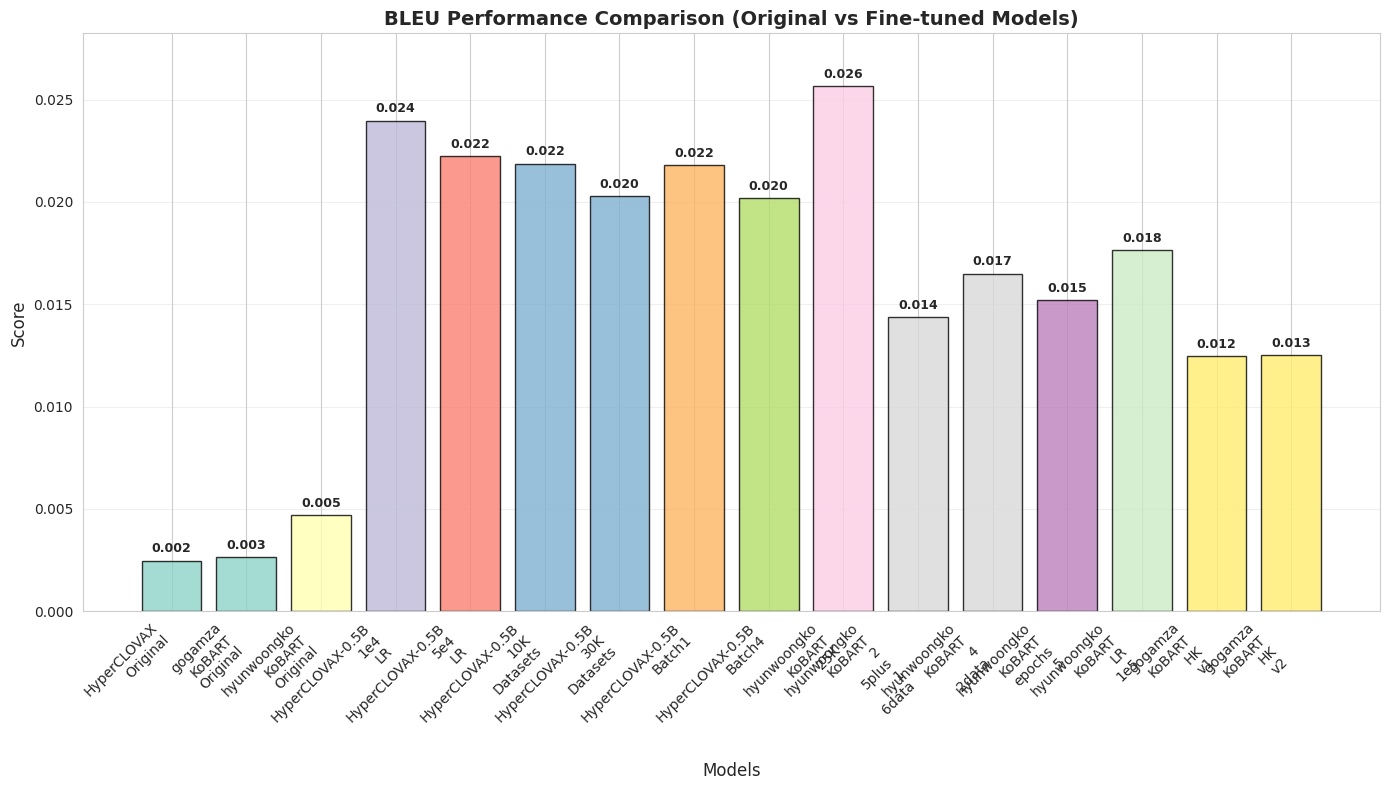

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_02_rouge_1_comparison.png


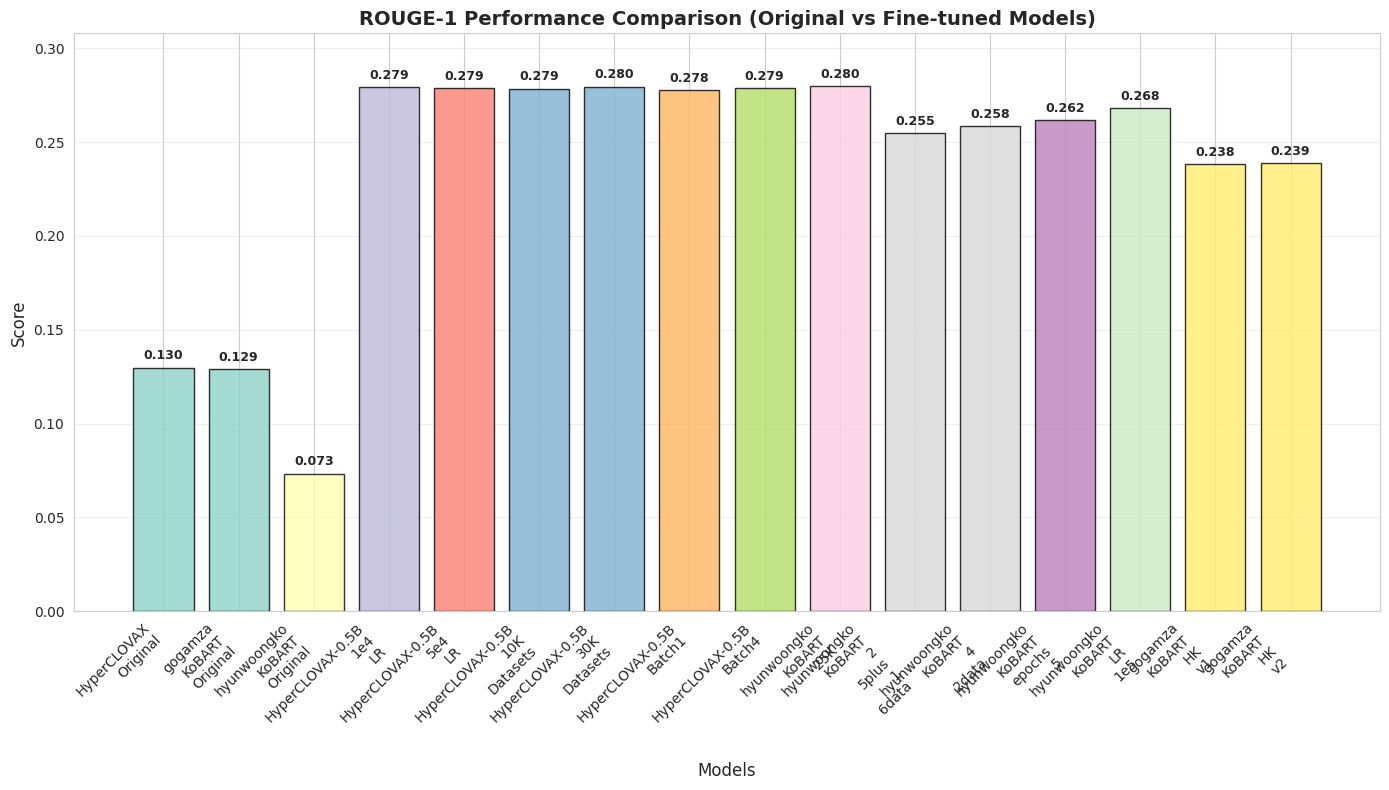

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_03_rouge_2_comparison.png


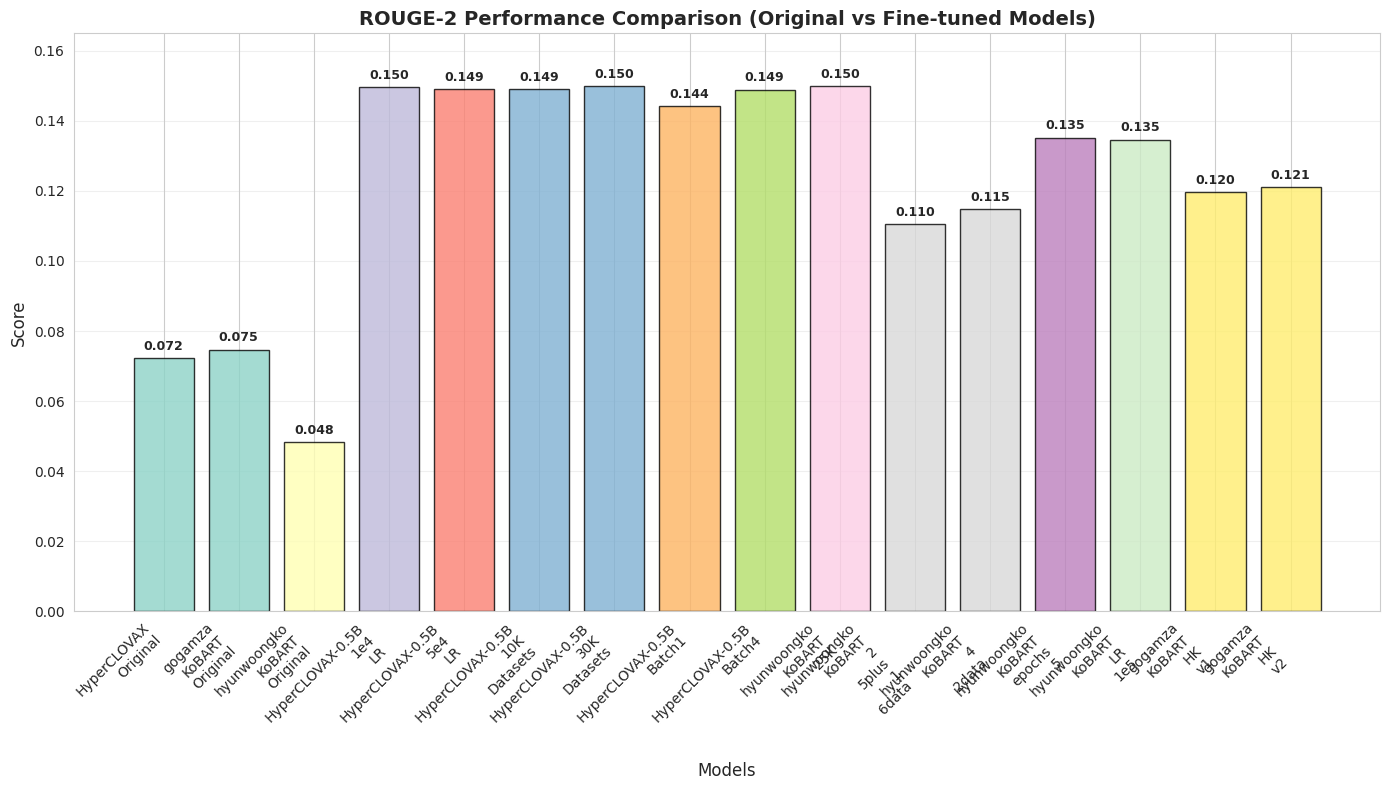

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_04_rouge_l_comparison.png


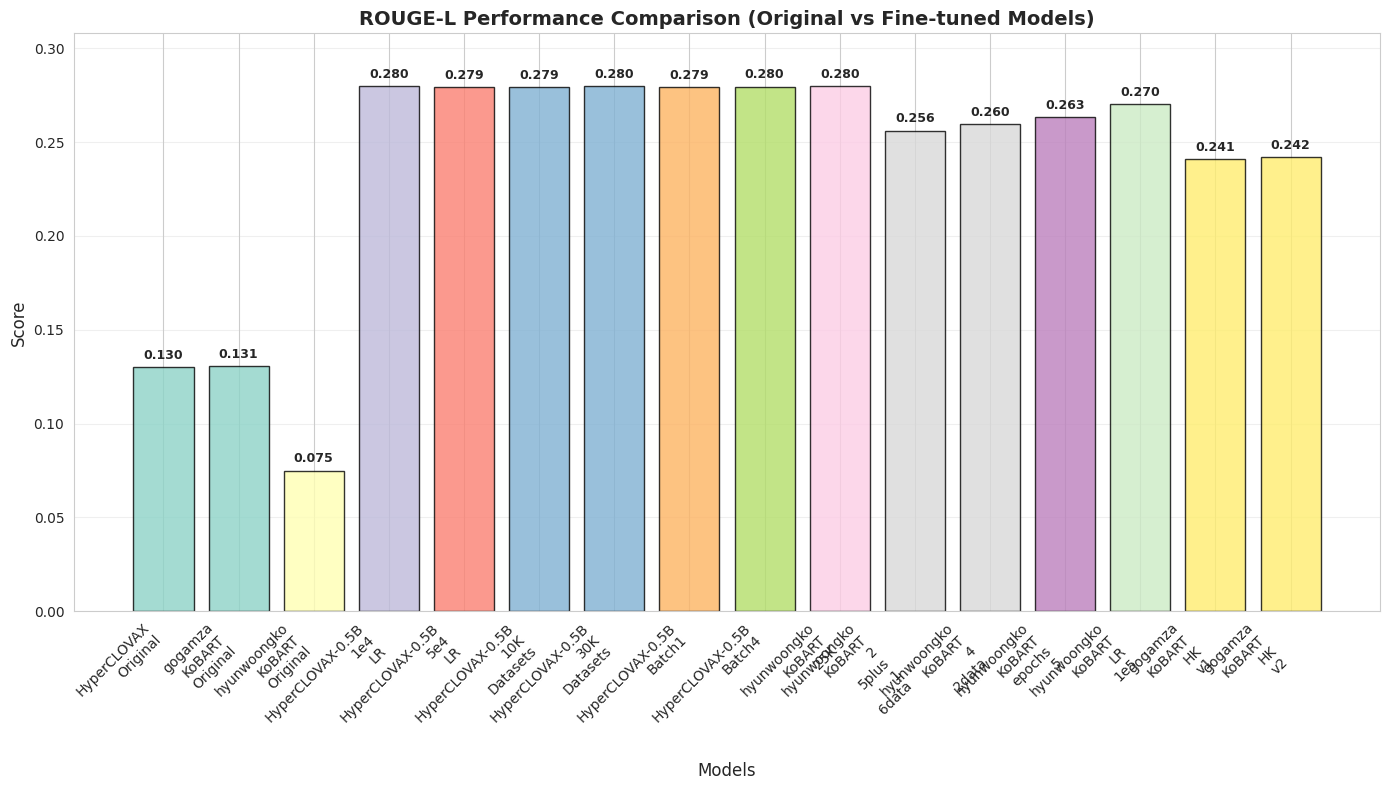

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_05_character_accuracy_comparison.png


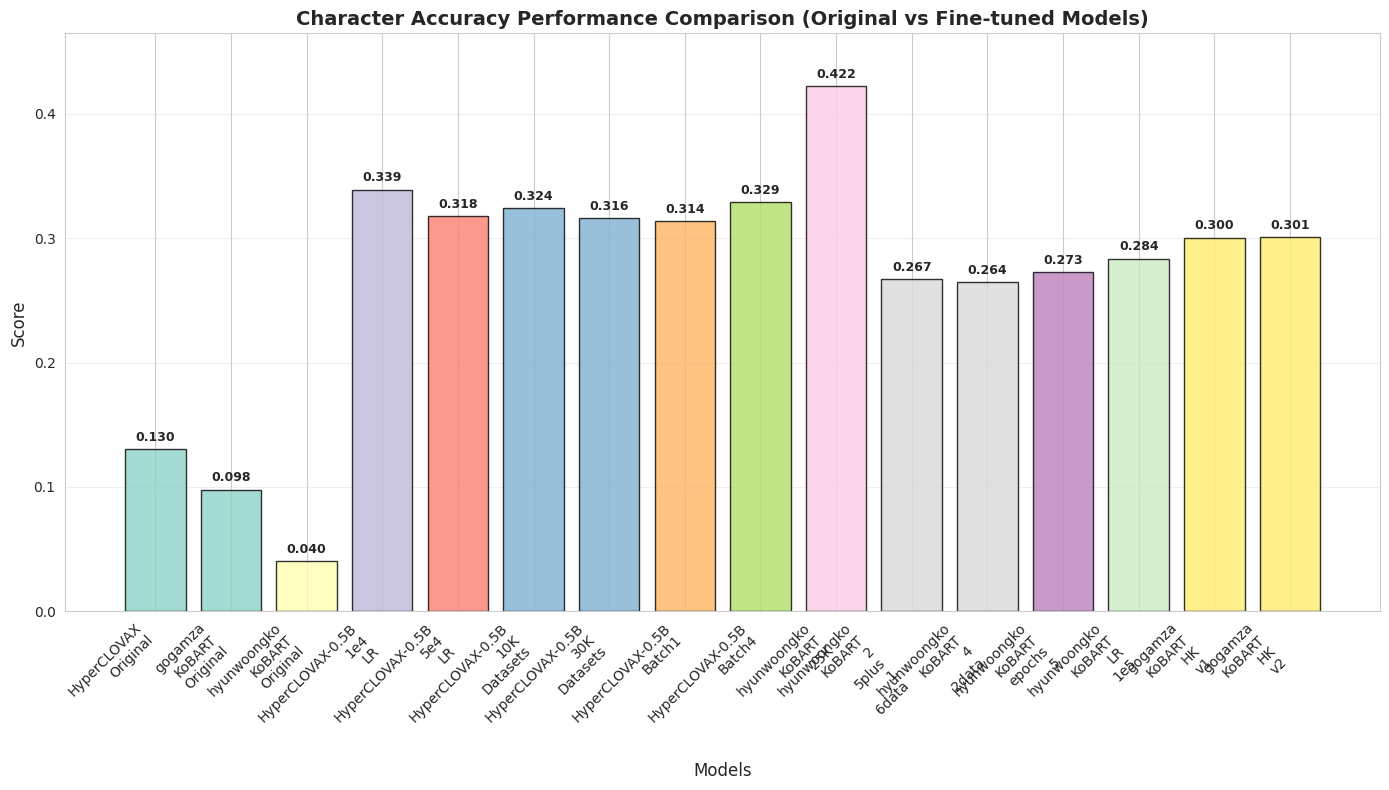

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_06_exact_match_comparison.png


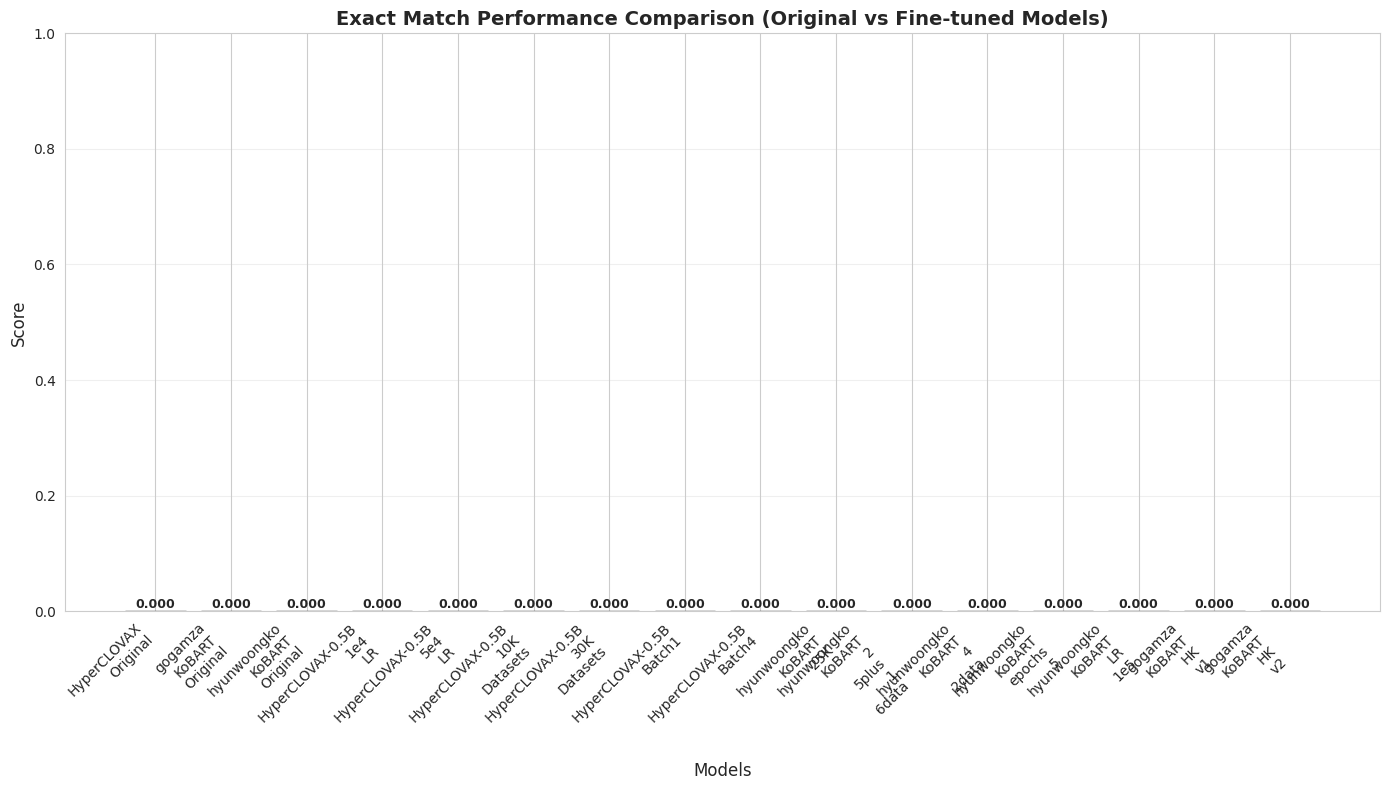

종합 이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/01_00_comprehensive_performance_all_metrics.png


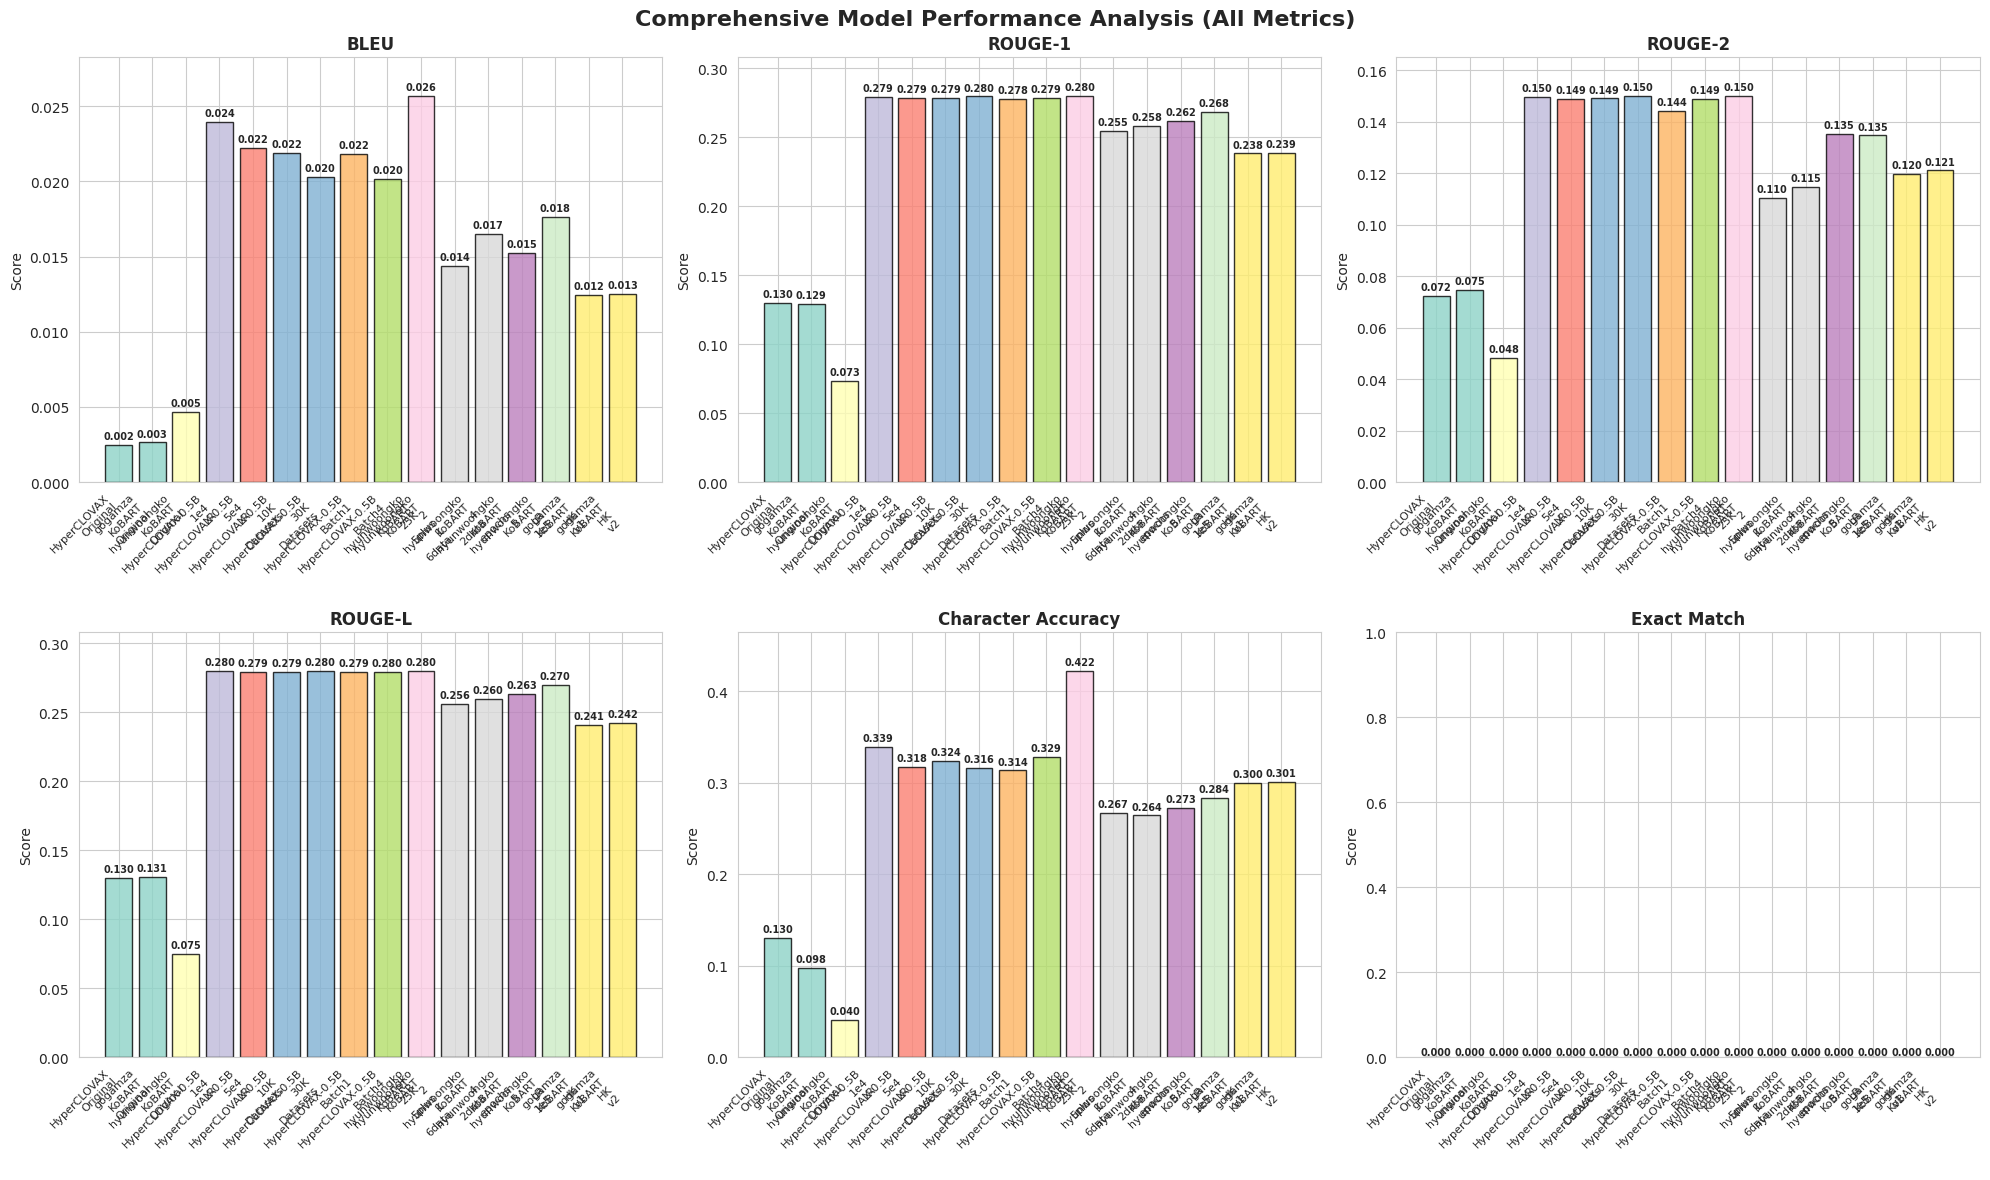

In [13]:
# 전체 모델 성능 비교 분석
print("\n=== All Models Performance Comparison ===")

# 1. 종합 성능 비교 차트 - 개별 이미지로 분리
model_names_list = list(all_results.keys())
n_models = len(model_names_list)

# 색상 팔레트 생성 (모델 수에 따라 동적 조정)
colors = plt.cm.Set3(np.linspace(0, 1, n_models))

metrics_data = {
    'BLEU': [all_results[name]['bleu'] for name in model_names_list],
    'ROUGE-1': [all_results[name]['rouge1'] for name in model_names_list],
    'ROUGE-2': [all_results[name]['rouge2'] for name in model_names_list],
    'ROUGE-L': [all_results[name]['rougeL'] for name in model_names_list],
    'Character Accuracy': [all_results[name]['char_accuracy'] for name in model_names_list],
    'Exact Match': [all_results[name]['exact_match'] for name in model_names_list]
}

# 각 메트릭별로 개별 이미지 생성
for idx, (metric, values) in enumerate(metrics_data.items()):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    bars = ax.bar(range(n_models), values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric} Performance Comparison (Original vs Fine-tuned Models)',
                 fontweight='bold', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylim(0, max(values) * 1.1 if max(values) > 0 else 1)

    # 모델 이름 라벨 (각도 조정)
    ax.set_xticks(range(n_models))
    ax.set_xticklabels([name.replace('_', '\n') for name in model_names_list],
                       rotation=45, ha='right', fontsize=10)

    # 값 표시
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
               f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 그리드 추가
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    # 개별 이미지 저장
    metric_safe_name = metric.replace('-', '_').replace(' ', '_').lower()
    img_path = os.path.join(image_save_dir, f'01_{idx+1:02d}_{metric_safe_name}_comparison.png')
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    print(f"이미지 저장: {img_path}")
    plt.show()

# 추가로 모든 메트릭을 한 번에 보여주는 종합 차트도 생성
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Model Performance Analysis (All Metrics)', fontsize=16, fontweight='bold')

for idx, (metric, values) in enumerate(metrics_data.items()):
    row = idx // 3
    col = idx % 3

    bars = axes[row, col].bar(range(n_models), values, color=colors, alpha=0.8, edgecolor='black')
    axes[row, col].set_title(f'{metric}', fontweight='bold', fontsize=12)
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_ylim(0, max(values) * 1.1 if max(values) > 0 else 1)

    # 모델 이름 라벨 (각도 조정)
    axes[row, col].set_xticks(range(n_models))
    axes[row, col].set_xticklabels([name.replace('_', '\n') for name in model_names_list],
                                   rotation=45, ha='right', fontsize=8)

    # 값 표시
    for bar, value in zip(bars, values):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=7)

plt.tight_layout()
# 종합 이미지 저장
img_path = os.path.join(image_save_dir, '01_00_comprehensive_performance_all_metrics.png')
plt.savefig(img_path, dpi=300, bbox_inches='tight')
print(f"종합 이미지 저장: {img_path}")
plt.show()

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/02_character_accuracy_distribution.png


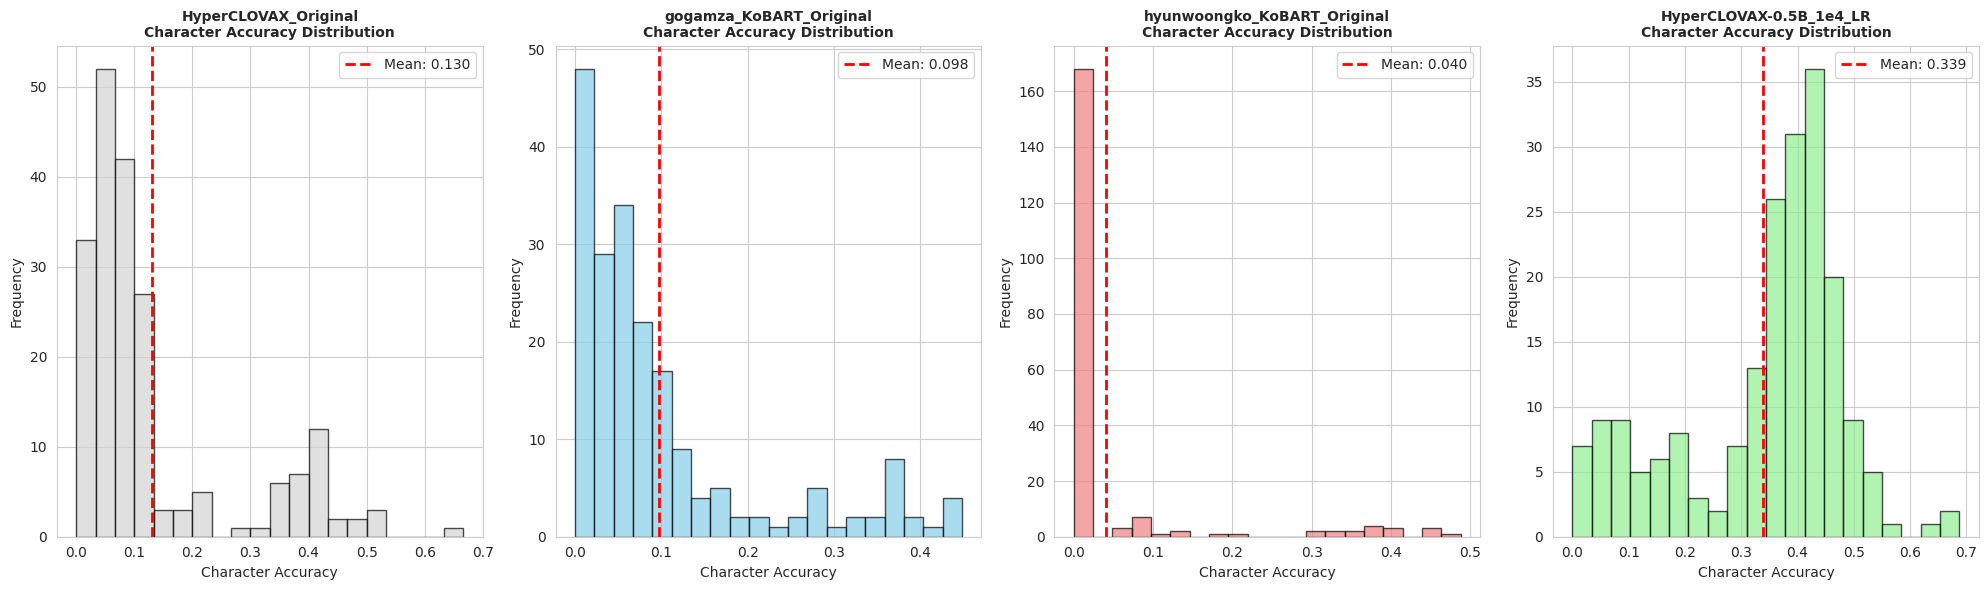

In [14]:
# 2. 문자 정확도 분포 비교
n_models = len(model_names_list)
fig, axes = plt.subplots(1, min(n_models, 4), figsize=(5*min(n_models, 4), 6))

# 모델 수가 1개인 경우 axes를 리스트로 만들기
if n_models == 1:
    axes = [axes]
elif n_models <= 4:
    pass  # axes는 이미 리스트
else:
    # 4개 이상인 경우 첫 4개만 표시
    model_names_list = model_names_list[:4]
    n_models = 4

colors_hist = ['lightgray', 'skyblue', 'lightcoral', 'lightgreen', 'plum', 'orange']

for i, model_name in enumerate(model_names_list[:min(n_models, 4)]):
    char_accuracies = all_results[model_name]['char_accuracies']
    mean_accuracy = all_results[model_name]['char_accuracy']

    axes[i].hist(char_accuracies, bins=20, alpha=0.7, color=colors_hist[i % len(colors_hist)], edgecolor='black')
    axes[i].set_title(f'{model_name}\nCharacter Accuracy Distribution', fontweight='bold', fontsize=10)
    axes[i].set_xlabel('Character Accuracy')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(mean_accuracy, color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {mean_accuracy:.3f}')
    axes[i].legend()

plt.tight_layout()
# 이미지 저장
img_path = os.path.join(image_save_dir, '02_character_accuracy_distribution.png')
plt.savefig(img_path, dpi=300, bbox_inches='tight')
print(f"이미지 저장: {img_path}")
plt.show()

이미지 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images/03_inference_time_comparison.png


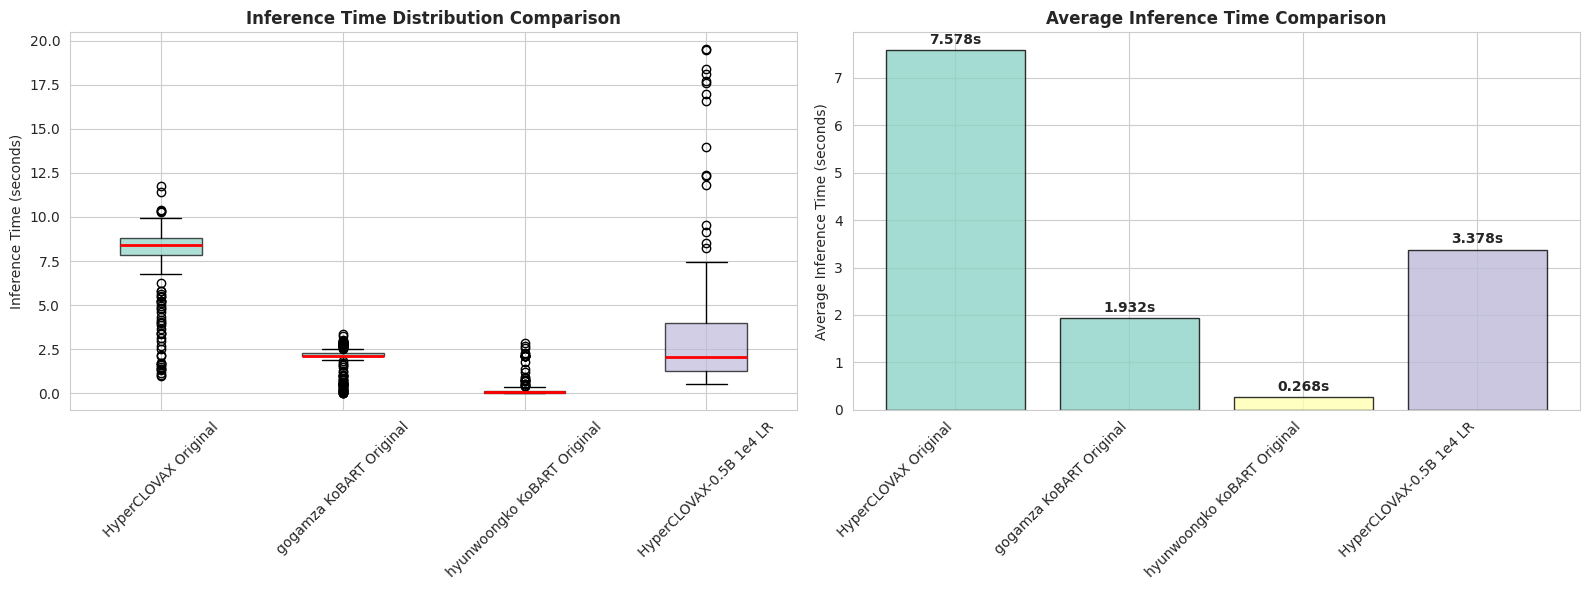

In [15]:
# 3. 추론 시간 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 추론 시간 분포 비교 (Box Plot)
inference_data = [all_results[name]['inference_times'] for name in model_names_list]
labels = [name.replace('_', ' ') for name in model_names_list]

box_plot = axes[0].boxplot(inference_data, labels=labels, patch_artist=True)

# 박스 색상 설정
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for median in box_plot['medians']:
    median.set_color('red')
    median.set_linewidth(2)

axes[0].set_title('Inference Time Distribution Comparison', fontweight='bold')
axes[0].set_ylabel('Inference Time (seconds)')
axes[0].tick_params(axis='x', rotation=45)

# 평균 추론 시간 막대 차트
avg_times = [all_results[name]['avg_inference_time'] for name in model_names_list]
bars = axes[1].bar(range(len(model_names_list)), avg_times, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title('Average Inference Time Comparison', fontweight='bold')
axes[1].set_ylabel('Average Inference Time (seconds)')
axes[1].set_xticks(range(len(model_names_list)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')

# 값 표시
for bar, time_val in zip(bars, avg_times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_times)*0.01,
                f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
# 이미지 저장
img_path = os.path.join(image_save_dir, '03_inference_time_comparison.png')
plt.savefig(img_path, dpi=300, bbox_inches='tight')
print(f"이미지 저장: {img_path}")
plt.show()

## 9. Qualitative Analysis - Example Comparison

In [16]:
# 모든 모델 간 성능 차이가 큰 샘플들 찾기
def find_performance_differences(all_results, n_samples=5):
    """모든 모델 간 성능 차이가 큰 샘플들 찾기"""
    base_model_name = 'Base Model'  # 영어 키로 변경

    if base_model_name not in all_results:
        print("Base model not available for performance difference analysis.")
        return None, None, None

    base_accuracies = np.array(all_results[base_model_name]['char_accuracies'])

    # 가장 성능이 좋은 모델 찾기
    best_model_name = base_model_name
    best_overall_accuracy = np.mean(base_accuracies)

    for model_name in all_results.keys():
        if model_name != base_model_name:
            model_accuracy = all_results[model_name]['char_accuracy']
            if model_accuracy > best_overall_accuracy:
                best_overall_accuracy = model_accuracy
                best_model_name = model_name

    if best_model_name == base_model_name:
        print("Fine-tuned models do not outperform the base model.")
        return None, None, None

    best_accuracies = np.array(all_results[best_model_name]['char_accuracies'])

    # 미세조정 효과가 가장 큰 인덱스
    improvement = best_accuracies - base_accuracies
    best_improvement_idx = np.argsort(improvement)[-n_samples:][::-1]
    worst_improvement_idx = np.argsort(improvement)[:n_samples]

    return best_improvement_idx, worst_improvement_idx, best_model_name

best_imp_idx, worst_imp_idx, best_model = find_performance_differences(all_results)

if best_imp_idx is not None:
    base_results = all_results['Base Model']  # 영어 키로 변경
    best_results = all_results[best_model]

    print(f"=== Most Effective Fine-tuning Examples ({best_model} vs Base Model) ===")
    for i, idx in enumerate(best_imp_idx):
        print(f"\n[Example {i+1}]")
        print(f"난독화 텍스트: {base_results['test_data'].iloc[idx]['obfuscated']}")
        print(f"정답 텍스트: {base_results['references'][idx]}")
        print(f"베이스 모델 예측: {base_results['predictions'][idx]}")
        print(f"{best_model} 예측: {best_results['predictions'][idx]}")
        print(f"Character Accuracy - Base: {base_results['char_accuracies'][idx]:.3f}, {best_model}: {best_results['char_accuracies'][idx]:.3f}")
        print("-" * 120)

    print(f"\n=== Limited Fine-tuning Effect Examples ===")
    for i, idx in enumerate(worst_imp_idx):
        print(f"\n[Example {i+1}]")
        print(f"난독화 텍스트: {base_results['test_data'].iloc[idx]['obfuscated']}")
        print(f"정답 텍스트: {base_results['references'][idx]}")
        print(f"베이스 모델 예측: {base_results['predictions'][idx]}")
        print(f"{best_model} 예측: {best_results['predictions'][idx]}")
        print(f"Character Accuracy - Base: {base_results['char_accuracies'][idx]:.3f}, {best_model}: {best_results['char_accuracies'][idx]:.3f}")
        print("-" * 120)

    # 전반적인 성능 비교 통계
    print("\n=== Overall Performance Comparison Statistics ===")
    base_char_acc = np.array(base_results['char_accuracies'])
    best_char_acc = np.array(best_results['char_accuracies'])

    better_count = np.sum(best_char_acc > base_char_acc)
    worse_count = np.sum(best_char_acc < base_char_acc)
    tie_count = np.sum(best_char_acc == base_char_acc)

    print(f"{best_model} > Base Model: {better_count} cases ({better_count/len(base_char_acc)*100:.1f}%)")
    print(f"{best_model} < Base Model: {worse_count} cases ({worse_count/len(base_char_acc)*100:.1f}%)")
    print(f"Ties: {tie_count} cases ({tie_count/len(base_char_acc)*100:.1f}%)")

    avg_improvement = np.mean(best_char_acc - base_char_acc)
    print(f"\nAverage performance improvement of {best_model} vs Base: {avg_improvement:.4f} ({avg_improvement*100:.2f}%p)")
else:
    print("Performance difference analysis could not be performed.")

Base model not available for performance difference analysis.
Performance difference analysis could not be performed.


=== Category-wise Performance Analysis ===

Original Models Category:
  HyperCLOVAX_Original: 0.1302
  gogamza_KoBART_Original: 0.0977
  hyunwoongko_KoBART_Original: 0.0403
  → Best Performance: HyperCLOVAX_Original (0.1302)

Learning Rate Variants Category:
  HyperCLOVAX-0.5B_1e4_LR: 0.3390
  HyperCLOVAX-0.5B_5e4_LR: 0.3177
  → Best Performance: HyperCLOVAX-0.5B_1e4_LR (0.3390)

Dataset Size Variants Category:
  HyperCLOVAX-0.5B_10K_Datasets: 0.3243
  HyperCLOVAX-0.5B_30K_Datasets: 0.3160
  → Best Performance: HyperCLOVAX-0.5B_10K_Datasets (0.3243)

Batch Size Variants Category:
  HyperCLOVAX-0.5B_Batch1: 0.3136
  HyperCLOVAX-0.5B_Batch4: 0.3289
  → Best Performance: HyperCLOVAX-0.5B_Batch4 (0.3289)

gogamza KoBART Fine-tuned Category:
  gogamza_KoBART_HK_v1: 0.3004
  gogamza_KoBART_HK_v2: 0.3006
  → Best Performance: gogamza_KoBART_HK_v2 (0.3006)

hyunwoongko KoBART Fine-tuned Category:
  hyunwoongko_KoBART_25K: 0.4225
  → Best Performance: hyunwoongko_KoBART_25K (0.4225)

hyunwoongk

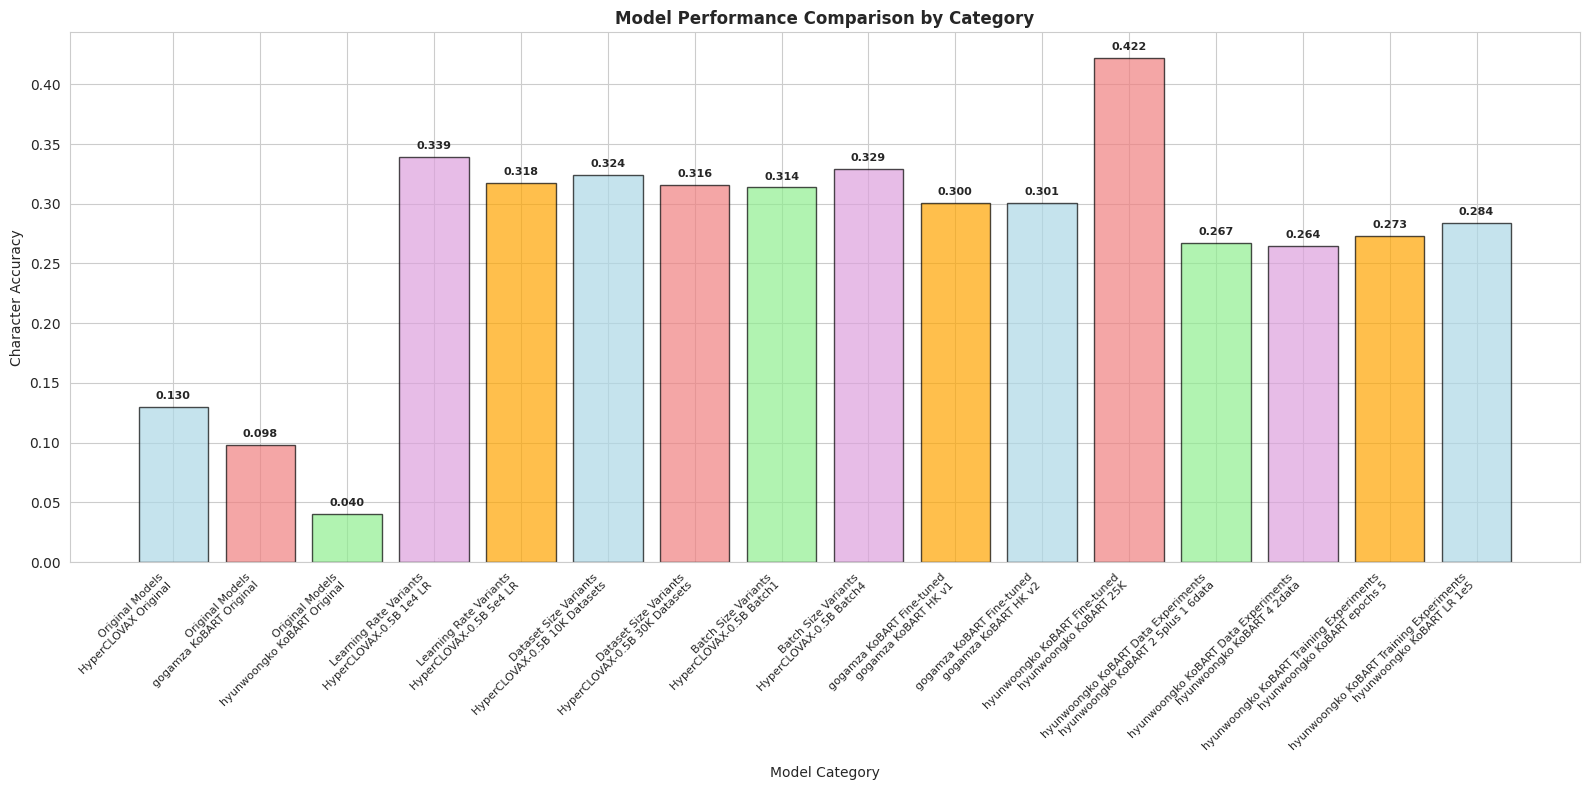

In [17]:
# 모델 카테고리별 비교 분석
def categorize_models_updated(all_results):
    """모델들을 카테고리별로 분류 (업데이트된 버전)"""
    categories = {
        'Original Models': [],
        'Learning Rate Variants': [],
        'Dataset Size Variants': [],
        'Batch Size Variants': [],
        'gogamza KoBART Fine-tuned': [],
        'hyunwoongko KoBART Fine-tuned': [],
        'hyunwoongko KoBART Data Experiments': [],
        'hyunwoongko KoBART Training Experiments': []
    }

    for model_name in all_results.keys():
        if 'Original' in model_name:
            categories['Original Models'].append(model_name)
        elif 'LR' in model_name and 'HyperCLOVAX' in model_name:
            categories['Learning Rate Variants'].append(model_name)
        elif 'Datasets' in model_name:
            categories['Dataset Size Variants'].append(model_name)
        elif 'Batch' in model_name:
            categories['Batch Size Variants'].append(model_name)
        elif 'gogamza_KoBART' in model_name and 'Original' not in model_name:
            categories['gogamza KoBART Fine-tuned'].append(model_name)
        elif 'hyunwoongko_KoBART' in model_name and 'Original' not in model_name:
            # hyunwoongko KoBART 모델들을 세부 분류
            if 'data' in model_name:
                categories['hyunwoongko KoBART Data Experiments'].append(model_name)
            elif 'epochs' in model_name or 'LR_1e5' in model_name:
                categories['hyunwoongko KoBART Training Experiments'].append(model_name)
            else:
                categories['hyunwoongko KoBART Fine-tuned'].append(model_name)

    return categories

# 카테고리별 성능 분석
model_categories = categorize_models_updated(all_results)

# 카테고리별 최고 성능 모델 식별
print("=== Category-wise Performance Analysis ===")
for category, models in model_categories.items():
    if models:
        print(f"\n{category} Category:")
        best_model_in_category = None
        best_accuracy_in_category = 0

        for model in models:
            accuracy = all_results[model]['char_accuracy']
            print(f"  {model}: {accuracy:.4f}")

            if accuracy > best_accuracy_in_category:
                best_accuracy_in_category = accuracy
                best_model_in_category = model

        if best_model_in_category:
            print(f"  → Best Performance: {best_model_in_category} ({best_accuracy_in_category:.4f})")

# 카테고리별 성능 비교 시각화
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

category_names = []
category_scores = []
category_colors = ['lightblue', 'lightcoral', 'lightgreen', 'plum', 'orange']

for i, (category, models) in enumerate(model_categories.items()):
    if models:
        for model in models:
            category_names.append(f"{category}\n{model.replace('_', ' ')}")
            category_scores.append(all_results[model]['char_accuracy'])

bars = ax.bar(range(len(category_names)), category_scores,
              color=[category_colors[i % len(category_colors)] for i in range(len(category_names))],
              alpha=0.7, edgecolor='black')

ax.set_xlabel('Model Category')
ax.set_ylabel('Character Accuracy')
ax.set_title('Model Performance Comparison by Category', fontweight='bold')
ax.set_xticks(range(len(category_names)))
ax.set_xticklabels(category_names, rotation=45, ha='right', fontsize=8)

# 값 표시
for bar, score in zip(bars, category_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.tight_layout()
# 이미지 저장
img_path = os.path.join(image_save_dir, '04_category_performance_comparison.png')
plt.savefig(img_path, dpi=300, bbox_inches='tight')
print(f"이미지 저장: {img_path}")
plt.show()

🔍 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 모델 종합 성능 분석 - 최종 결론

📊 **전체 모델 성능 분석 (16개 모델 비교)**

원본 모델: 3개
  • HyperCLOVAX_Original: 0.1302
  • gogamza_KoBART_Original: 0.0977
  • hyunwoongko_KoBART_Original: 0.0403

파인튜닝 모델: 13개

📈 **메트릭별 최고 성능 모델:**
  • BLEU: hyunwoongko_KoBART_25K (Fine-tuned, 0.0257)
  • ROUGE1: hyunwoongko_KoBART_25K (Fine-tuned, 0.2800)
  • ROUGE2: HyperCLOVAX-0.5B_30K_Datasets (Fine-tuned, 0.1500)
  • ROUGEL: HyperCLOVAX-0.5B_1e4_LR (Fine-tuned, 0.2800)
  • CHAR_ACCURACY: hyunwoongko_KoBART_25K (Fine-tuned, 0.4225)
  • EXACT_MATCH: 데이터 없음

🏆 **전체 최고 성능 모델**: hyunwoongko_KoBART_25K
   Character Accuracy: 0.4225
   Model Type: Fine-tuned

🎯 **파인튜닝 효과 분석:**
  • HyperCLOVAX-0.5B 계열:
    - 원본: 0.1302
    - 최고 파인튜닝: HyperCLOVAX-0.5B_1e4_LR (0.3390)
    - 개선율: +160.39%
  • gogamza KoBART 계열:
    - 원본: 0.0977
    - 최고 파인튜닝: gogamza_KoBART_HK_v2 (0.3006)
    - 개선율: +207.75%
  • hyunwoongko KoBART 계열:
    - 원본: 0.0403
    - 최고 파인튜닝: hyunwoongko_KoBART_25K (0.4225)
    - 개선율: +947.

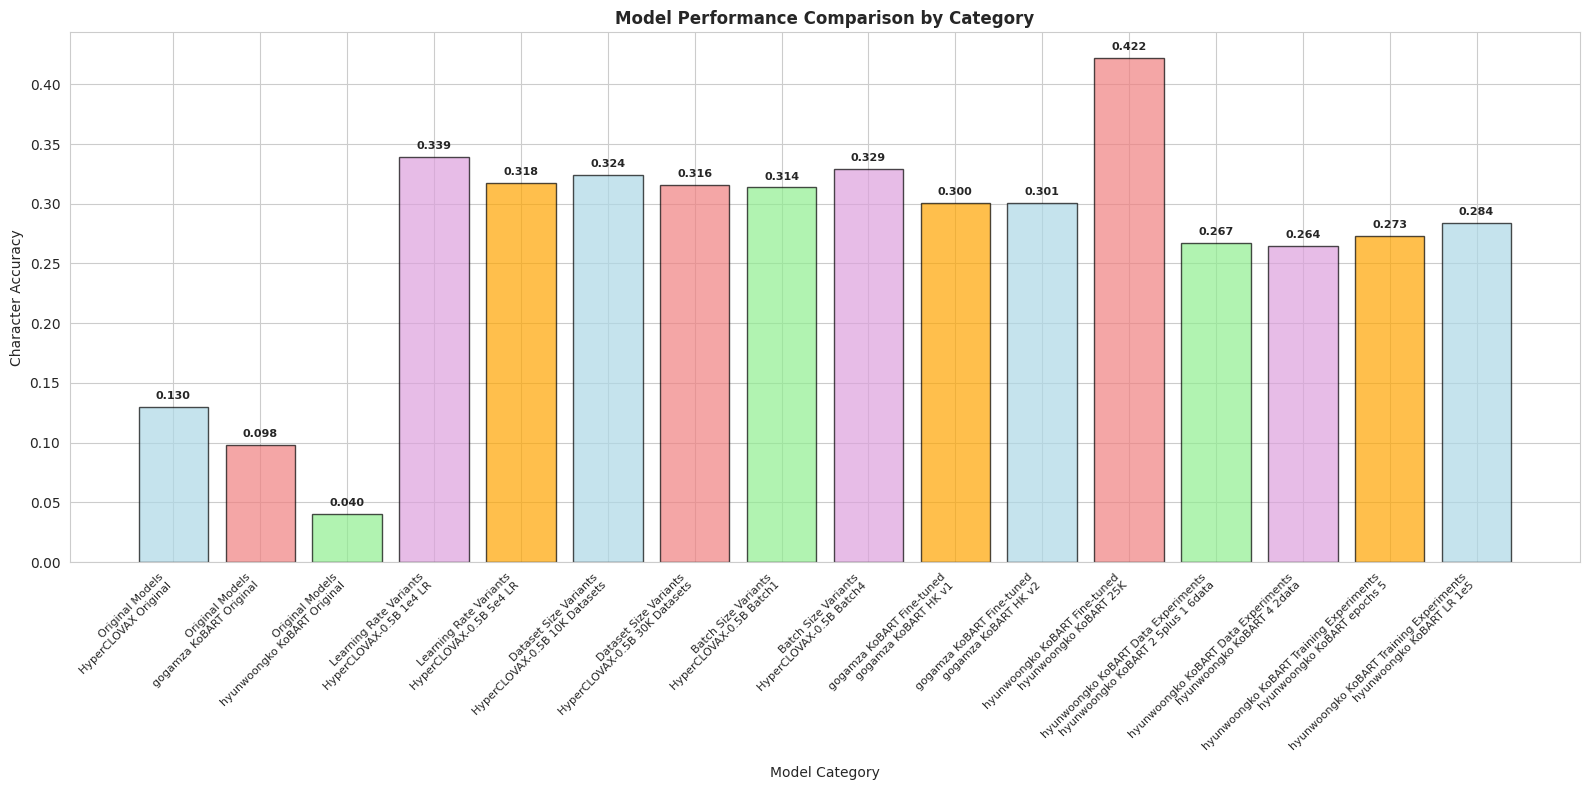


✅ 분석 완료!


In [18]:
print("=" * 90)
print("🔍 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 모델 종합 성능 분석 - 최종 결론")
print("=" * 90)

# all_results 존재 여부 및 유효성 검사
if 'all_results' not in globals() or all_results is None or not all_results:
    print("\n❌ **분석 결과가 없습니다.**")
    print("모델 평가가 아직 실행되지 않았거나 실패했습니다.")
    print("이전 셀들을 다시 실행해주세요.")
else:
    model_names_list = list(all_results.keys())

    print(f"\n📊 **전체 모델 성능 분석 ({len(all_results)}개 모델 비교)**\n")

    # 원본 모델과 파인튜닝 모델 분리
    original_models = [name for name in model_names_list if 'Original' in name]
    finetuned_models = [name for name in model_names_list if 'Original' not in name]

    print(f"원본 모델: {len(original_models)}개")
    for model in original_models:
        accuracy = all_results[model]['char_accuracy']
        print(f"  • {model}: {accuracy:.4f}")

    print(f"\n파인튜닝 모델: {len(finetuned_models)}개")

    # 최고 성능 모델들 찾기 (None 체크 포함)
    best_models = {}
    metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match']

    for metric in metrics:
        best_score = 0
        best_model = None

        for model_name in model_names_list:
            try:
                score = all_results[model_name][metric]
                if score > best_score:
                    best_score = score;
                    best_model = model_name
            except (KeyError, TypeError):
                continue

        best_models[metric] = (best_model, best_score)

    # 메트릭별 최고 성능 모델 출력 (None 체크 포함)
    print("\n📈 **메트릭별 최고 성능 모델:**")
    for metric, (model, score) in best_models.items():
        if model is not None:
            model_type = "Original" if 'Original' in model else "Fine-tuned"
            print(f"  • {metric.upper()}: {model} ({model_type}, {score:.4f})")
        else:
            print(f"  • {metric.upper()}: 데이터 없음")

    # 전반적 최고 성능 모델 (문자 정확도 기준)
    if 'char_accuracy' in best_models and best_models['char_accuracy'][0] is not None:
        overall_best_model, overall_best_score = best_models['char_accuracy']

        print(f"\n🏆 **전체 최고 성능 모델**: {overall_best_model}")
        print(f"   Character Accuracy: {overall_best_score:.4f}")
        print(f"   Model Type: {'Original' if 'Original' in overall_best_model else 'Fine-tuned'}")

        # 파인튜닝 효과 분석
        print(f"\n🎯 **파인튜닝 효과 분석:**")

        # HyperCLOVAX 계열 분석
        if 'HyperCLOVAX_Original' in all_results:
            try:
                hyperclova_original_score = all_results['HyperCLOVAX_Original']['char_accuracy']
                hyperclova_finetuned = [name for name in finetuned_models if 'HyperCLOVAX-0.5B' in name]

                if hyperclova_finetuned:
                    best_hyperclova_ft = max(hyperclova_finetuned, key=lambda x: all_results[x]['char_accuracy'])
                    best_hyperclova_score = all_results[best_hyperclova_ft]['char_accuracy']
                    if hyperclova_original_score > 0:
                        hyperclova_improvement = ((best_hyperclova_score - hyperclova_original_score) / hyperclova_original_score * 100)

                        print(f"  • HyperCLOVAX-0.5B 계열:")
                        print(f"    - 원본: {hyperclova_original_score:.4f}")
                        print(f"    - 최고 파인튜닝: {best_hyperclova_ft} ({best_hyperclova_score:.4f})")
                        print(f"    - 개선율: {hyperclova_improvement:+.2f}%")
            except (KeyError, TypeError) as e:
                print(f"  • HyperCLOVAX-0.5B 계열: 분석 실패 ({e})")

        # gogamza KoBART 계열 분석
        if 'gogamza_KoBART_Original' in all_results:
            try:
                gogamza_kobart_original_score = all_results['gogamza_KoBART_Original']['char_accuracy']
                gogamza_kobart_finetuned = [name for name in finetuned_models if 'gogamza_KoBART' in name]

                if gogamza_kobart_finetuned:
                    best_gogamza_kobart_ft = max(gogamza_kobart_finetuned, key=lambda x: all_results[x]['char_accuracy'])
                    best_gogamza_kobart_score = all_results[best_gogamza_kobart_ft]['char_accuracy']
                    if gogamza_kobart_original_score > 0:
                        gogamza_kobart_improvement = ((best_gogamza_kobart_score - gogamza_kobart_original_score) / gogamza_kobart_original_score * 100)

                        print(f"  • gogamza KoBART 계열:")
                        print(f"    - 원본: {gogamza_kobart_original_score:.4f}")
                        print(f"    - 최고 파인튜닝: {best_gogamza_kobart_ft} ({best_gogamza_kobart_score:.4f})")
                        print(f"    - 개선율: {gogamza_kobart_improvement:+.2f}%")
            except (KeyError, TypeError) as e:
                print(f"  • gogamza KoBART 계열: 분석 실패 ({e})")

        # hyunwoongko KoBART 계열 분석
        if 'hyunwoongko_KoBART_Original' in all_results:
            try:
                hyunwoongko_kobart_original_score = all_results['hyunwoongko_KoBART_Original']['char_accuracy']
                hyunwoongko_kobart_finetuned = [name for name in finetuned_models if 'hyunwoongko_KoBART' in name]

                if hyunwoongko_kobart_finetuned:
                    best_hyunwoongko_kobart_ft = max(hyunwoongko_kobart_finetuned, key=lambda x: all_results[x]['char_accuracy'])
                    best_hyunwoongko_kobart_score = all_results[best_hyunwoongko_kobart_ft]['char_accuracy']
                    if hyunwoongko_kobart_original_score > 0:
                        hyunwoongko_kobart_improvement = ((best_hyunwoongko_kobart_score - hyunwoongko_kobart_original_score) / hyunwoongko_kobart_original_score * 100)

                        print(f"  • hyunwoongko KoBART 계열:")
                        print(f"    - 원본: {hyunwoongko_kobart_original_score:.4f}")
                        print(f"    - 최고 파인튜닝: {best_hyunwoongko_kobart_ft} ({best_hyunwoongko_kobart_score:.4f})")
                        print(f"    - 개선율: {hyunwoongko_kobart_improvement:+.2f}%")
            except (KeyError, TypeError) as e:
                print(f"  • hyunwoongko KoBART 계열: 분석 실패 ({e})")

    else:
        print("\n⚠️ **최고 성능 모델을 찾을 수 없습니다.**")

    # 카테고리별 성능 비교 시각화 (all_results가 유효할 때만)
    if 'model_categories' in globals() and model_categories is not None:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))

            category_names = []
            category_scores = []
            category_colors = ['lightblue', 'lightcoral', 'lightgreen', 'plum', 'orange']

            for i, (category, models) in enumerate(model_categories.items()):
                if models:
                    for model in models:
                        if model in all_results and 'char_accuracy' in all_results[model]:
                            category_names.append(f"{category}\n{model.replace('_', ' ')}")
                            category_scores.append(all_results[model]['char_accuracy'])

            if category_names and category_scores:
                bars = ax.bar(range(len(category_names)), category_scores,
                              color=[category_colors[i % len(category_colors)] for i in range(len(category_names))],
                              alpha=0.7, edgecolor='black')

                ax.set_xlabel('Model Category')
                ax.set_ylabel('Character Accuracy')
                ax.set_title('Model Performance Comparison by Category', fontweight='bold')
                ax.set_xticks(range(len(category_names)))
                ax.set_xticklabels(category_names, rotation=45, ha='right', fontsize=8)

                # 값 표시
                for bar, score in zip(bars, category_scores):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

                plt.tight_layout()
                # 이미지 저장
                img_path = os.path.join(image_save_dir, '05_final_category_performance_comparison.png')
                plt.savefig(img_path, dpi=300, bbox_inches='tight')
                print(f"\n📊 이미지 저장: {img_path}")
                plt.show()
            else:
                print("\n⚠️ 시각화할 카테고리 데이터가 없습니다.")
        except Exception as e:
            print(f"\n⚠️ 시각화 생성 중 오류 발생: {e}")
    else:
        print("\n⚠️ 카테고리 분석 데이터가 없습니다.")

    print("\n" + "=" * 90)
    print("✅ 분석 완료!")
    print("=" * 90)

## 10. 성능 결과 CSV 파일 추출

In [19]:
# 성능 결과를 CSV 파일로 추출
import csv
from datetime import datetime

def export_performance_to_csv(all_results, analysis_root_dir):
    """성능 평가 결과를 CSV 파일로 저장"""

    if not all_results:
        print("❌ 분석 결과가 없습니다. CSV 추출을 건너뜁니다.")
        return

    # CSV 저장 폴더 생성
    csv_export_dir = os.path.join(analysis_root_dir, 'csv_exports')
    os.makedirs(csv_export_dir, exist_ok=True)

    # 현재 시간 (파일명에 사용)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. 전체 모델 성능 요약 CSV
    summary_csv_path = os.path.join(csv_export_dir, f'model_performance_summary_{timestamp}.csv')

    summary_data = []
    metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match', 'avg_inference_time', 'total_inference_time']

    for model_name in all_results.keys():
        result = all_results[model_name]
        row = {
            'Model_Name': model_name,
            'Model_Type': 'Original' if 'Original' in model_name else 'Fine-tuned',
            'Model_Family': get_model_family(model_name),
            'BLEU_Score': f"{result['bleu']:.6f}",
            'ROUGE_1': f"{result['rouge1']:.6f}",
            'ROUGE_2': f"{result['rouge2']:.6f}",
            'ROUGE_L': f"{result['rougeL']:.6f}",
            'Character_Accuracy': f"{result['char_accuracy']:.6f}",
            'Exact_Match_Rate': f"{result['exact_match']:.6f}",
            'Avg_Inference_Time_Sec': f"{result['avg_inference_time']:.6f}",
            'Total_Inference_Time_Sec': f"{result['total_inference_time']:.2f}",
            'Test_Samples': len(result['predictions']),
            'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        summary_data.append(row)

    # 문자 정확도로 정렬
    summary_data.sort(key=lambda x: float(x['Character_Accuracy']), reverse=True)

    # CSV 저장
    fieldnames = list(summary_data[0].keys())
    with open(summary_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(summary_data)

    print(f"✅ 전체 모델 성능 요약 CSV 저장: {summary_csv_path}")

    # 2. 상세 예측 결과 CSV (샘플별)
    detailed_csv_path = os.path.join(csv_export_dir, f'detailed_predictions_{timestamp}.csv')

    detailed_data = []

    # 각 모델의 예측 결과를 하나의 CSV로 통합
    for model_name, result in all_results.items():
        test_data = result['test_data']
        predictions = result['predictions']
        references = result['references']
        char_accuracies = result['char_accuracies']
        exact_matches = result['exact_matches']
        inference_times = result['inference_times']

        for idx in range(len(predictions)):
            row = {
                'Sample_ID': idx + 1,
                'Model_Name': model_name,
                'Model_Type': 'Original' if 'Original' in model_name else 'Fine-tuned',
                'Model_Family': get_model_family(model_name),
                'Obfuscated_Text': test_data.iloc[idx]['obfuscated'] if hasattr(test_data, 'iloc') else test_data[idx]['obfuscated'],
                'Reference_Text': references[idx],
                'Predicted_Text': predictions[idx],
                'Character_Accuracy': f"{char_accuracies[idx]:.6f}",
                'Exact_Match': int(exact_matches[idx]),
                'Inference_Time_Sec': f"{inference_times[idx]:.6f}",
                'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
            detailed_data.append(row)

    # CSV 저장
    detailed_fieldnames = list(detailed_data[0].keys()) if detailed_data else []
    with open(detailed_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=detailed_fieldnames)
        writer.writeheader()
        writer.writerows(detailed_data)

    print(f"✅ 상세 예측 결과 CSV 저장: {detailed_csv_path}")

    # 3. 카테고리별 성능 비교 CSV
    category_csv_path = os.path.join(csv_export_dir, f'category_performance_{timestamp}.csv')

    category_data = []
    if 'model_categories' in globals() and model_categories:
        for category, models in model_categories.items():
            if models:
                for model in models:
                    if model in all_results:
                        result = all_results[model]
                        row = {
                            'Category': category,
                            'Model_Name': model,
                            'BLEU_Score': f"{result['bleu']:.6f}",
                            'ROUGE_1': f"{result['rouge1']:.6f}",
                            'ROUGE_2': f"{result['rouge2']:.6f}",
                            'ROUGE_L': f"{result['rougeL']:.6f}",
                            'Character_Accuracy': f"{result['char_accuracy']:.6f}",
                            'Exact_Match_Rate': f"{result['exact_match']:.6f}",
                            'Avg_Inference_Time_Sec': f"{result['avg_inference_time']:.6f}",
                            'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        }
                        category_data.append(row)

        # 카테고리별로 정렬
        category_data.sort(key=lambda x: (x['Category'], -float(x['Character_Accuracy'])))

        # CSV 저장
        category_fieldnames = list(category_data[0].keys()) if category_data else []
        with open(category_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=category_fieldnames)
            writer.writeheader()
            writer.writerows(category_data)

        print(f"✅ 카테고리별 성능 비교 CSV 저장: {category_csv_path}")

    # 4. 최고 성능 모델 정보 CSV
    best_models_csv_path = os.path.join(csv_export_dir, f'best_models_by_metric_{timestamp}.csv')

    best_models_data = []
    metrics_for_best = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match']

    for metric in metrics_for_best:
        best_score = 0
        best_model = None

        for model_name in all_results.keys():
            try:
                score = all_results[model_name][metric]
                if score > best_score:
                    best_score = score
                    best_model = model_name
            except (KeyError, TypeError):
                continue

        if best_model:
            row = {
                'Metric': metric.upper(),
                'Best_Model': best_model,
                'Best_Score': f"{best_score:.6f}",
                'Model_Type': 'Original' if 'Original' in best_model else 'Fine-tuned',
                'Model_Family': get_model_family(best_model),
                'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
            best_models_data.append(row)

    # CSV 저장
    best_models_fieldnames = list(best_models_data[0].keys()) if best_models_data else []
    with open(best_models_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=best_models_fieldnames)
        writer.writeheader()
        writer.writerows(best_models_data)

    print(f"✅ 최고 성능 모델 정보 CSV 저장: {best_models_csv_path}")

    # 5. 모델 비교 개선율 CSV (원본 vs 파인튜닝)
    improvement_csv_path = os.path.join(csv_export_dir, f'finetuning_improvement_{timestamp}.csv')

    improvement_data = []
    metrics_for_improvement = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'char_accuracy', 'exact_match']

    # HyperCLOVAX 계열 분석
    if 'HyperCLOVAX_Original' in all_results:
        hyperclova_original = all_results['HyperCLOVAX_Original']
        hyperclova_finetuned = [name for name in all_results.keys() if 'HyperCLOVAX-0.5B' in name]

        for ft_model in hyperclova_finetuned:
            ft_result = all_results[ft_model]
            for metric in metrics_for_improvement:
                original_score = hyperclova_original[metric]
                ft_score = ft_result[metric]

                if original_score > 0:
                    improvement_pct = ((ft_score - original_score) / original_score) * 100
                else:
                    improvement_pct = 0

                row = {
                    'Model_Family': 'HyperCLOVAX',
                    'Original_Model': 'HyperCLOVAX_Original',
                    'Finetuned_Model': ft_model,
                    'Metric': metric.upper(),
                    'Original_Score': f"{original_score:.6f}",
                    'Finetuned_Score': f"{ft_score:.6f}",
                    'Improvement_Percentage': f"{improvement_pct:.2f}",
                    'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                }
                improvement_data.append(row)

    # gogamza KoBART 계열 분석
    if 'gogamza_KoBART_Original' in all_results:
        gogamza_kobart_original = all_results['gogamza_KoBART_Original']
        gogamza_kobart_finetuned = [name for name in all_results.keys() if 'gogamza_KoBART' in name and 'Original' not in name]

        for ft_model in gogamza_kobart_finetuned:
            ft_result = all_results[ft_model]
            for metric in metrics_for_improvement:
                original_score = gogamza_kobart_original[metric]
                ft_score = ft_result[metric]

                if original_score > 0:
                    improvement_pct = ((ft_score - original_score) / original_score) * 100
                else:
                    improvement_pct = 0

                row = {
                    'Model_Family': 'gogamza_KoBART',
                    'Original_Model': 'gogamza_KoBART_Original',
                    'Finetuned_Model': ft_model,
                    'Metric': metric.upper(),
                    'Original_Score': f"{original_score:.6f}",
                    'Finetuned_Score': f"{ft_score:.6f}",
                    'Improvement_Percentage': f"{improvement_pct:.2f}",
                    'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                }
                improvement_data.append(row)

    # hyunwoongko KoBART 계열 분석
    if 'hyunwoongko_KoBART_Original' in all_results:
        hyunwoongko_kobart_original = all_results['hyunwoongko_KoBART_Original']
        hyunwoongko_kobart_finetuned = [name for name in all_results.keys() if 'hyunwoongko_KoBART' in name and 'Original' not in name]

        for ft_model in hyunwoongko_kobart_finetuned:
            ft_result = all_results[ft_model]
            for metric in metrics_for_improvement:
                original_score = hyunwoongko_kobart_original[metric]
                ft_score = ft_result[metric]

                if original_score > 0:
                    improvement_pct = ((ft_score - original_score) / original_score) * 100
                else:
                    improvement_pct = 0

                row = {
                    'Model_Family': 'hyunwoongko_KoBART',
                    'Original_Model': 'hyunwoongko_KoBART_Original',
                    'Finetuned_Model': ft_model,
                    'Metric': metric.upper(),
                    'Original_Score': f"{original_score:.6f}",
                    'Finetuned_Score': f"{ft_score:.6f}",
                    'Improvement_Percentage': f"{improvement_pct:.2f}",
                    'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                }
                improvement_data.append(row)

    # CSV 저장
    if improvement_data:
        improvement_fieldnames = list(improvement_data[0].keys())
        with open(improvement_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=improvement_fieldnames)
            writer.writeheader()
            writer.writerows(improvement_data)

        print(f"✅ 파인튜닝 개선율 CSV 저장: {improvement_csv_path}")

    # 요약 정보 출력
    print(f"\n📁 모든 CSV 파일이 저장된 폴더: {csv_export_dir}")
    print("\n📊 생성된 CSV 파일 목록:")
    print(f"  1. 전체 모델 성능 요약: {os.path.basename(summary_csv_path)}")
    print(f"  2. 상세 예측 결과: {os.path.basename(detailed_csv_path)}")
    if category_data:
        print(f"  3. 카테고리별 성능 비교: {os.path.basename(category_csv_path)}")
    print(f"  4. 최고 성능 모델 정보: {os.path.basename(best_models_csv_path)}")
    if improvement_data:
        print(f"  5. 파인튜닝 개선율: {os.path.basename(improvement_csv_path)}")

    return csv_export_dir

def get_model_family(model_name):
    """모델명에서 모델 패밀리 추출"""
    if 'HyperCLOVAX' in model_name:
        return 'HyperCLOVAX'
    elif 'gogamza_KoBART' in model_name:
        return 'gogamza_KoBART'
    elif 'hyunwoongko_KoBART' in model_name:
        return 'hyunwoongko_KoBART'
    else:
        return 'Unknown'

# CSV 추출 실행
if 'all_results' in globals() and all_results:
    print("📥 성능 평가 결과를 CSV 파일로 추출합니다...")
    csv_export_dir = export_performance_to_csv(all_results, analysis_root_dir)

    # 전체 모델 성능 요약을 데이터프레임으로도 표시
    print("\n📊 전체 모델 성능 요약 (상위 10개):")
    summary_df = pd.DataFrame([
        {
            'Model_Name': model_name,
            'Model_Type': 'Original' if 'Original' in model_name else 'Fine-tuned',
            'BLEU': f"{result['bleu']:.4f}",
            'ROUGE-1': f"{result['rouge1']:.4f}",
            'ROUGE-L': f"{result['rougeL']:.4f}",
            'Char_Acc': f"{result['char_accuracy']:.4f}",
            'Exact_Match': f"{result['exact_match']:.4f}",
            'Avg_Time(s)': f"{result['avg_inference_time']:.3f}"
        }
        for model_name, result in all_results.items()
    ])

    # 문자 정확도로 정렬
    summary_df['Char_Acc_Float'] = summary_df['Char_Acc'].astype(float)
    summary_df = summary_df.sort_values('Char_Acc_Float', ascending=False).drop('Char_Acc_Float', axis=1)

    print(summary_df.head(10).to_string(index=False))

else:
    print("❌ 분석 결과가 없어 CSV 추출을 수행할 수 없습니다.")
    print("이전 셀에서 모델 평가를 먼저 실행해주세요.")

📥 성능 평가 결과를 CSV 파일로 추출합니다...
✅ 전체 모델 성능 요약 CSV 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports/model_performance_summary_20250603_071357.csv
✅ 상세 예측 결과 CSV 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports/detailed_predictions_20250603_071357.csv
✅ 카테고리별 성능 비교 CSV 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports/category_performance_20250603_071357.csv
✅ 최고 성능 모델 정보 CSV 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports/best_models_by_metric_20250603_071357.csv
✅ 파인튜닝 개선율 CSV 저장: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports/finetuning_improvement_20250603_071357.csv

📁 모든 CSV 파일이 저장된 폴더: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_exports

📊 생성된 CSV 파일 목록:
  1. 전체 모델 성능 요약: model_performance_summary_20250603_071357.csv
  2. 상세 예측 결과: detailed_predictions_20250603_071357.csv
  3. 카테고리별 성능 비교: category

## 11. 최고 성능 모델 Gradio 인터페이스

In [20]:
# Gradio 설치 및 임포트
!pip install -q gradio

import gradio as gr
import torch
import time
from datetime import datetime

# 최고 성능 모델 식별 및 로드
def identify_best_model():
    """분석 결과에서 최고 성능 모델 식별"""
    if not all_results:
        print("❌ 분석 결과가 없습니다.")
        return None, None, None

    best_model_name = None
    best_accuracy = 0
    best_model = None

    # 문자 정확도 기준으로 최고 성능 모델 찾기
    for model_name, result in all_results.items():
        char_accuracy = result['char_accuracy']
        if char_accuracy > best_accuracy:
            best_accuracy = char_accuracy
            best_model_name = model_name
            best_model = loaded_models.get(model_name)

    if best_model is None:
        print(f"⚠️ 최고 성능 모델 {best_model_name}이 로드되지 않았습니다.")
        return None, None, None

    print(f"🏆 최고 성능 모델: {best_model_name}")
    print(f"   문자 정확도: {best_accuracy:.4f}")
    print(f"   모델 타입: {'Original' if 'Original' in best_model_name else 'Fine-tuned'}")

    return best_model_name, best_model, best_accuracy

# 최고 성능 모델 식별
best_model_name, best_model, best_accuracy = identify_best_model()

if best_model is not None:
    print(f"\n✅ Gradio 인터페이스를 위한 최고 성능 모델 준비 완료: {best_model_name}")
else:
    print("❌ Gradio 인터페이스를 실행할 수 없습니다. 모델이 로드되지 않았습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.7 MB/s eta 0:00:00
🏆 최고 성능 모델: hyunwoongko_KoBART_25K
   문자 정확도: 0.4225
   모델 타입: Fine-tuned

✅ Gradio 인터페이스를 위한 최고 성능 모델 준비 완료: hyunwoongko_KoBART_25K


In [21]:
def gradio_deobfuscate(obfuscated_text, temperature=0.7, top_p=0.9, max_length=256):
    """Gradio용 난독화 해제 함수"""
    if best_model is None:
        return "❌ 모델이 로드되지 않았습니다.", 0.0, ""

    if not obfuscated_text.strip():
        return "❌ 입력 텍스트를 입력해주세요.", 0.0, ""

    try:
        start_time = time.time()

        # 모델 타입에 따른 처리
        if 'KoBART' in best_model_name:
            # KoBART 모델 처리
            model_tokenizer = None

            if best_model_name in kobart_tokenizers:
                model_tokenizer = kobart_tokenizers[best_model_name]
            elif 'gogamza' in best_model_name and 'gogamza_KoBART_Original' in kobart_tokenizers:
                model_tokenizer = kobart_tokenizers['gogamza_KoBART_Original']
            elif 'hyunwoongko' in best_model_name and 'hyunwoongko_KoBART_Original' in kobart_tokenizers:
                model_tokenizer = kobart_tokenizers['hyunwoongko_KoBART_Original']

            if model_tokenizer is None:
                return "❌ 토크나이저를 찾을 수 없습니다.", 0.0, ""

            # 특수 토큰 확인 및 설정
            if model_tokenizer.pad_token is None:
                model_tokenizer.pad_token = model_tokenizer.eos_token

            # BartForConditionalGeneration을 위한 입력 준비
            if hasattr(best_model, 'generate') and 'BartForConditionalGeneration' in str(type(best_model)):
                inputs = model_tokenizer(
                    obfuscated_text,
                    return_tensors="pt",
                    truncation=True,
                    max_length=512,
                    padding=True
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = best_model.generate(
                        input_ids=inputs['input_ids'],
                        attention_mask=inputs.get('attention_mask'),
                        max_length=max_length,
                        do_sample=True,
                        temperature=temperature,
                        top_p=top_p,
                        num_beams=3,
                        pad_token_id=model_tokenizer.pad_token_id,
                        eos_token_id=model_tokenizer.eos_token_id,
                        early_stopping=True
                    )

                response = model_tokenizer.decode(outputs[0], skip_special_tokens=True)
            else:
                response = obfuscated_text  # 폴백

        else:
            # HyperCLOVAX 모델 처리
            prompt = f"""### 지시사항:
다음 난독화된 한국어 텍스트를 원래 텍스트로 복원해주세요.

난독화된 텍스트: {obfuscated_text}

### 응답:
"""

            inputs = hyperclova_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = best_model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=temperature,
                    top_p=top_p,
                    pad_token_id=hyperclova_tokenizer.eos_token_id,
                    eos_token_id=hyperclova_tokenizer.eos_token_id
                )

            response = hyperclova_tokenizer.decode(outputs[0], skip_special_tokens=True)

            # 응답 부분만 추출
            if "### 응답:" in response:
                response = response.split("### 응답:")[1].strip()
                if "<|endoftext|>" in response:
                    response = response.split("<|endoftext|>")[0].strip()

        inference_time = time.time() - start_time

        # 성능 정보 생성
        performance_info = f"""
🏆 **모델**: {best_model_name}
📊 **성능 점수**: {best_accuracy:.4f} (문자 정확도)
⏱️ **추론 시간**: {inference_time:.3f}초
🌡️ **Temperature**: {temperature}
🎯 **Top-p**: {top_p}
📏 **Max Length**: {max_length}
🕐 **생성 시간**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

        return response.strip(), inference_time, performance_info

    except Exception as e:
        error_msg = f"❌ 오류 발생: {str(e)}"
        return error_msg, 0.0, ""

# Gradio 인터페이스 생성 (모델이 로드된 경우에만)
if best_model is not None:

    # 예시 텍스트들 (테스트 데이터에서 샘플링)
    example_texts = []
    if 'test_df' in globals() and not test_df.empty:
        # 테스트 데이터에서 랜덤 샘플 5개 선택
        sample_indices = test_df.sample(n=min(5, len(test_df)), random_state=42).index
        for idx in sample_indices:
            example_texts.append([test_df.iloc[idx]['obfuscated']])

    # 예시 텍스트가 없는 경우 기본 예시
    if not example_texts:
        example_texts = [
            ["ㅎㅏㄴㄱㅜㄱㅇㅓ ㄴㅏㄴㄷㅗㄱㅎㅘ ㅎㅐㅈㅔ"],
            ["ㅁㅏㅅㅣㄴㄹㅓㄴㅣㅇ ㅁㅗㄷㅔㄹ"],
            ["ㅇㅏㅇㅣ ㅌㅔㅅㅌㅡ"],
            ["ㅍㅏㅇㅣㄴㅌㅠㄴㅣㅇ ㅅㅓㅇㄱㅗㅇ"],
            ["ㅈㅏㅇㅕㄴㅓ ㅊㅓㄹㅣ"]
        ]

    # Gradio 인터페이스 정의
    def create_gradio_interface():
        with gr.Blocks(
            title="91veMe4Plus 팀 - 난독화 한국어 텍스트 원본 복원 시스템",
            theme=gr.themes.Soft(),
            css="""
            .gradio-container {
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }
            .main-header {
                text-align: center;
                background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 20px;
                border-radius: 10px;
                margin-bottom: 20px;
            }
            .model-info {
                background: #f0f8ff;
                padding: 15px;
                border-radius: 8px;
                border-left: 4px solid #4CAF50;
                margin-bottom: 20px;
            }
            """
        ) as demo:

            # 헤더
            gr.HTML("""
            <div class="main-header">
                <h1>🚀 91veMe4Plus 팀 - 난독화 한국어 텍스트 원본 복원 시스템</h1>
                <p>최고 성능 모델을 사용하여 난독화된 한국어 텍스트를 원본으로 복원합니다</p>
            </div>
            """)

            # 모델 정보
            gr.HTML(f"""
            <div class="model-info">
                <h3>🏆 현재 사용 중인 최고 성능 모델</h3>
                <ul>
                    <li><strong>모델명:</strong> {best_model_name}</li>
                    <li><strong>모델 타입:</strong> {'원본 모델' if 'Original' in best_model_name else '파인튜닝 모델'}</li>
                    <li><strong>문자 정확도:</strong> {best_accuracy:.4f}</li>
                    <li><strong>모델 패밀리:</strong> {get_model_family(best_model_name)}</li>
                </ul>
            </div>
            """)

            with gr.Row():
                with gr.Column(scale=2):
                    # 입력 섹션
                    gr.Markdown("## 📝 입력")

                    obfuscated_input = gr.Textbox(
                        label="난독화된 텍스트",
                        placeholder="난독화된 한국어 텍스트를 입력하세요 (예: ㅎㅏㄴㄱㅜㄱㅇㅓ)",
                        lines=3,
                        max_lines=5
                    )

                    with gr.Row():
                        temperature = gr.Slider(
                            minimum=0.1,
                            maximum=1.5,
                            value=0.7,
                            step=0.1,
                            label="Temperature (창의성 조절)"
                        )
                        top_p = gr.Slider(
                            minimum=0.1,
                            maximum=1.0,
                            value=0.9,
                            step=0.05,
                            label="Top-p (다양성 조절)"
                        )
                        max_length = gr.Slider(
                            minimum=64,
                            maximum=512,
                            value=256,
                            step=32,
                            label="최대 생성 길이"
                        )

                    with gr.Row():
                        submit_btn = gr.Button("🔄 복원하기", variant="primary", scale=2)
                        clear_btn = gr.Button("🗑️ 초기화", scale=1)

                with gr.Column(scale=2):
                    # 출력 섹션
                    gr.Markdown("## 📋 결과")

                    restored_output = gr.Textbox(
                        label="복원된 텍스트",
                        lines=3,
                        max_lines=5,
                        interactive=False
                    )

                    performance_output = gr.Markdown(
                        label="성능 정보",
                        value="복원 버튼을 클릭하면 성능 정보가 표시됩니다."
                    )

            # 예시 섹션
            gr.Markdown("## 💡 예시")
            gr.Examples(
                examples=example_texts,
                inputs=[obfuscated_input],
                outputs=[restored_output, gr.Number(visible=False), performance_output],
                fn=gradio_deobfuscate,
                cache_examples=False,
                label="클릭하여 예시 사용"
            )

            # 사용법 안내
            with gr.Accordion("📖 사용법 안내", open=False):
                gr.Markdown("""
                ### 사용 방법
                1. **난독화된 텍스트 입력**: 위의 텍스트박스에 난독화된 한국어 텍스트를 입력하세요.
                2. **파라미터 조정** (선택사항):
                   - **Temperature**: 낮을수록 안정적, 높을수록 창의적인 결과
                   - **Top-p**: 단어 선택의 다양성 조절
                   - **최대 생성 길이**: 생성할 텍스트의 최대 길이
                3. **복원하기 클릭**: 버튼을 클릭하여 원본 텍스트 복원
                4. **결과 확인**: 복원된 텍스트와 성능 정보 확인

                ### 팀 정보
                - **팀명**: 91veMe4Plus
                - **프로젝트**: 난독화 한국어 문자열 원본 추론 파인튜닝
                - **분석 대상**: 원본 모델 vs 다양한 파라미터 파인튜닝 모델 성능 비교
                """)

            # 이벤트 핸들러
            submit_btn.click(
                fn=gradio_deobfuscate,
                inputs=[obfuscated_input, temperature, top_p, max_length],
                outputs=[restored_output, gr.Number(visible=False), performance_output]
            )

            clear_btn.click(
                fn=lambda: ("", "", "복원 버튼을 클릭하면 성능 정보가 표시됩니다."),
                outputs=[obfuscated_input, restored_output, performance_output]
            )

        return demo

    # Gradio 인터페이스 생성 및 실행
    print("🚀 Gradio 인터페이스를 시작합니다...")
    print(f"📊 사용 모델: {best_model_name} (문자 정확도: {best_accuracy:.4f})")

    demo = create_gradio_interface()

    # 인터페이스 실행
    demo.launch(
        share=True,  # 공유 링크 생성
        show_api=False,  # API 문서 숨김
        show_error=True,  # 오류 표시
        height=800,  # 인터페이스 높이
        # server_name="0.0.0.0",  # 외부 접속 허용 (필요시 주석 해제)
        # server_port=7860,  # 포트 지정 (필요시 주석 해제)
        debug=False  # 디버그 모드
    )

else:
    print("❌ 최고 성능 모델이 로드되지 않아 Gradio 인터페이스를 실행할 수 없습니다.")
    print("이전 셀에서 모델 평가를 먼저 실행해주세요.")

🚀 Gradio 인터페이스를 시작합니다...
📊 사용 모델: hyunwoongko_KoBART_25K (문자 정확도: 0.4225)
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f56470af8a56a990fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 12. Gradio 인터페이스 추가 기능

In [ ]:
# 배치 처리 및 비교 기능이 포함된 고급 Gradio 인터페이스
def create_advanced_gradio_interface():
    """고급 기능이 포함된 Gradio 인터페이스"""

    if best_model is None:
        print("❌ 모델이 로드되지 않아 고급 인터페이스를 생성할 수 없습니다.")
        return None

    def batch_deobfuscate(text_list, temperature=0.7, top_p=0.9, max_length=256):
        """배치 처리 함수"""
        if not text_list.strip():
            return "❌ 입력 텍스트를 입력해주세요.", ""

        # 줄별로 분리
        texts = [line.strip() for line in text_list.split('\n') if line.strip()]
        results = []
        total_time = 0

        for i, text in enumerate(texts):
            try:
                restored, inf_time, _ = gradio_deobfuscate(text, temperature, top_p, max_length)
                results.append(f"{i+1}. 입력: {text}")
                results.append(f"   복원: {restored}")
                results.append("")  # 빈 줄 추가
                total_time += inf_time
            except Exception as e:
                results.append(f"{i+1}. 입력: {text}")
                results.append(f"   오류: {str(e)}")
                results.append("")

        batch_results = "\n".join(results)

        performance_info = f"""
### 📊 배치 처리 결과
- **처리된 텍스트 수**: {len(texts)}개
- **총 처리 시간**: {total_time:.3f}초
- **평균 처리 시간**: {total_time/len(texts):.3f}초/개
- **사용 모델**: {best_model_name}
"""

        return batch_results, performance_info

    def compare_with_original(obfuscated_text, temperature=0.7, top_p=0.9, max_length=256):
        """원본 모델과 최고 성능 모델 비교"""
        if not obfuscated_text.strip():
            return "❌ 입력 텍스트를 입력해주세요.", ""

        results = []

        # 최고 성능 모델 결과
        best_result, best_time, _ = gradio_deobfuscate(obfuscated_text, temperature, top_p, max_length)

        results.append(f"🏆 **최고 성능 모델** ({best_model_name}):")
        results.append(f"   복원 결과: {best_result}")
        results.append(f"   처리 시간: {best_time:.3f}초")
        results.append("")

        # 다른 모델들과 비교 (상위 3개 모델)
        model_performances = []
        for model_name, result in all_results.items():
            if model_name != best_model_name and model_name in loaded_models:
                model_performances.append((model_name, result['char_accuracy']))

        # 성능순으로 정렬하여 상위 2개 추가 비교
        model_performances.sort(key=lambda x: x[1], reverse=True)

        for model_name, accuracy in model_performances[:2]:
            try:
                model = loaded_models[model_name]
                comp_result, comp_time = generate_deobfuscated_text(model, obfuscated_text, model_name)

                results.append(f"📊 **{model_name}** (정확도: {accuracy:.4f}):")
                results.append(f"   복원 결과: {comp_result}")
                results.append(f"   처리 시간: {comp_time:.3f}초")
                results.append("")
            except Exception as e:
                results.append(f"❌ {model_name}: 오류 발생 ({str(e)})")
                results.append("")

        comparison_results = "\n".join(results)

        performance_info = f"""
### 🔍 모델 비교 분석
- **입력 텍스트**: {obfuscated_text}
- **비교 모델 수**: {len(model_performances[:2]) + 1}개
- **최고 성능 모델 정확도**: {best_accuracy:.4f}
"""

        return comparison_results, performance_info

    with gr.Blocks(
        title="91veMe4Plus 팀 - 고급 난독화 복원 시스템",
        theme=gr.themes.Soft(),
        css="""
        .gradio-container {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .main-header {
            text-align: center;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 25px;
            border-radius: 15px;
            margin-bottom: 25px;
            box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        }
        .tab-header {
            background: #f8f9fa;
            padding: 10px;
            border-radius: 8px;
            margin-bottom: 15px;
        }
        .performance-box {
            background: #e8f5e8;
            padding: 15px;
            border-radius: 8px;
            border-left: 4px solid #28a745;
        }
        """
    ) as advanced_demo:

        # 헤더
        gr.HTML("""
        <div class="main-header">
            <h1>🚀 91veMe4Plus 팀 - 고급 난독화 복원 시스템</h1>
            <p>최고 성능 AI 모델을 활용한 종합적인 난독화 한국어 텍스트 복원 솔루션</p>
            <small>✨ 단일 복원 | 📚 배치 처리 | 🔍 모델 비교 | 📊 성능 분석</small>
        </div>
        """)

        with gr.Tabs() as tabs:

            # 탭 1: 기본 복원
            with gr.TabItem("🔄 단일 텍스트 복원"):
                gr.HTML('<div class="tab-header"><h3>🔄 단일 텍스트 복원</h3><p>하나의 난독화된 텍스트를 복원합니다.</p></div>')

                with gr.Row():
                    with gr.Column(scale=1):
                        single_input = gr.Textbox(
                            label="난독화된 텍스트",
                            placeholder="난독화된 텍스트를 입력하세요",
                            lines=4
                        )

                        with gr.Row():
                            single_temp = gr.Slider(0.1, 1.5, 0.7, step=0.1, label="Temperature")
                            single_top_p = gr.Slider(0.1, 1.0, 0.9, step=0.05, label="Top-p")
                            single_max_len = gr.Slider(64, 512, 256, step=32, label="Max Length")

                        single_submit = gr.Button("🔄 복원하기", variant="primary")

                    with gr.Column(scale=1):
                        single_output = gr.Textbox(
                            label="복원된 텍스트",
                            lines=4,
                            interactive=False
                        )
                        single_perf = gr.Markdown("복원 버튼을 클릭하면 성능 정보가 표시됩니다.")

                # 예시
                gr.Examples(
                    examples=example_texts,
                    inputs=[single_input],
                    outputs=[single_output, gr.Number(visible=False), single_perf],
                    fn=gradio_deobfuscate
                )

            # 탭 2: 배치 처리
            with gr.TabItem("📚 배치 처리"):
                gr.HTML('<div class="tab-header"><h3>📚 배치 처리</h3><p>여러 개의 난독화된 텍스트를 한 번에 처리합니다.</p></div>')

                with gr.Row():
                    with gr.Column(scale=1):
                        batch_input = gr.Textbox(
                            label="난독화된 텍스트 목록 (줄별로 입력)",
                            placeholder="각 줄에 하나씩 난독화된 텍스트를 입력하세요\n예:\nㅎㅏㄴㄱㅜㄱㅇㅓ\nㅁㅏㅅㅣㄴㄹㅓㄴㅣㅇ",
                            lines=8
                        )

                        with gr.Row():
                            batch_temp = gr.Slider(0.1, 1.5, 0.7, step=0.1, label="Temperature")
                            batch_top_p = gr.Slider(0.1, 1.0, 0.9, step=0.05, label="Top-p")
                            batch_max_len = gr.Slider(64, 512, 256, step=32, label="Max Length")

                        batch_submit = gr.Button("📚 배치 처리 시작", variant="primary")

                    with gr.Column(scale=1):
                        batch_output = gr.Textbox(
                            label="배치 처리 결과",
                            lines=12,
                            interactive=False
                        )
                        batch_perf = gr.Markdown("배치 처리 버튼을 클릭하면 성능 정보가 표시됩니다.")

            # 탭 3: 모델 비교
            with gr.TabItem("🔍 모델 비교"):
                gr.HTML('<div class="tab-header"><h3>🔍 모델 비교</h3><p>최고 성능 모델과 다른 모델들의 복원 결과를 비교합니다.</p></div>')

                with gr.Row():
                    with gr.Column(scale=1):
                        compare_input = gr.Textbox(
                            label="비교할 난독화된 텍스트",
                            placeholder="모델 비교를 위한 난독화된 텍스트를 입력하세요",
                            lines=3
                        )

                        with gr.Row():
                            compare_temp = gr.Slider(0.1, 1.5, 0.7, step=0.1, label="Temperature")
                            compare_top_p = gr.Slider(0.1, 1.0, 0.9, step=0.05, label="Top-p")
                            compare_max_len = gr.Slider(64, 512, 256, step=32, label="Max Length")

                        compare_submit = gr.Button("🔍 모델 비교 시작", variant="primary")

                    with gr.Column(scale=1):
                        compare_output = gr.Textbox(
                            label="모델별 비교 결과",
                            lines=12,
                            interactive=False
                        )
                        compare_perf = gr.Markdown("모델 비교 버튼을 클릭하면 분석 정보가 표시됩니다.")

            # 탭 4: 성능 통계
            with gr.TabItem("📊 성능 통계"):
                gr.HTML('<div class="tab-header"><h3>📊 종합 성능 통계</h3><p>전체 모델들의 성능 분석 결과를 확인합니다.</p></div>')

                # 성능 통계 표시
                stats_md = f"""
                ### 🏆 최고 성능 모델 정보

                **모델명**: {best_model_name}
                **모델 타입**: {'원본 모델' if 'Original' in best_model_name else '파인튜닝 모델'}
                **문자 정확도**: {best_accuracy:.4f}
                **모델 패밀리**: {get_model_family(best_model_name)}

                ### 📈 전체 모델 성능 순위 (문자 정확도 기준)
                """

                # 성능 순위 테이블 생성
                performance_ranking = []
                for i, (model_name, result) in enumerate(
                    sorted(all_results.items(), key=lambda x: x[1]['char_accuracy'], reverse=True)
                ):
                    rank = i + 1
                    accuracy = result['char_accuracy']
                    model_type = '원본' if 'Original' in model_name else '파인튜닝'
                    avg_time = result['avg_inference_time']

                    performance_ranking.append(
                        f"{rank}. **{model_name}** ({model_type}) - 정확도: {accuracy:.4f}, 평균 시간: {avg_time:.3f}초"
                    )

                stats_md += "\n".join(performance_ranking)

                gr.Markdown(stats_md)

                # 추가 통계 정보
                total_models = len(all_results)
                original_models = len([name for name in all_results.keys() if 'Original' in name])
                finetuned_models = total_models - original_models

                gr.Markdown(f"""
                ### 📋 분석 요약

                - **총 분석 모델 수**: {total_models}개
                - **원본 모델**: {original_models}개
                - **파인튜닝 모델**: {finetuned_models}개
                - **테스트 샘플 수**: {len(all_results[best_model_name]['predictions'])}개
                - **분석 완료 시간**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                """)

        # 이벤트 바인딩
        single_submit.click(
            fn=gradio_deobfuscate,
            inputs=[single_input, single_temp, single_top_p, single_max_len],
            outputs=[single_output, gr.Number(visible=False), single_perf]
        )

        batch_submit.click(
            fn=batch_deobfuscate,
            inputs=[batch_input, batch_temp, batch_top_p, batch_max_len],
            outputs=[batch_output, batch_perf]
        )

        compare_submit.click(
            fn=compare_with_original,
            inputs=[compare_input, compare_temp, compare_top_p, compare_max_len],
            outputs=[compare_output, compare_perf]
        )

    return advanced_demo

# 고급 Gradio 인터페이스 실행
if best_model is not None:
    print("\n🚀 고급 Gradio 인터페이스를 시작합니다...")
    print("📋 기능: 단일 복원, 배치 처리, 모델 비교, 성능 통계")

    advanced_demo = create_advanced_gradio_interface()

    if advanced_demo is not None:
        # 인터페이스 실행
        advanced_demo.launch(
            share=True,
            show_api=False,
            show_error=True,
            height=900,
            debug=False,
            # 새로운 포트에서 실행 (기본 인터페이스와 충돌 방지)
            server_port=7861 if 'demo' in globals() else 7860
        )
    else:
        print("❌ 고급 인터페이스 생성에 실패했습니다.")
else:
    print("❌ 모델이 로드되지 않아 고급 인터페이스를 실행할 수 없습니다.")


🚀 고급 Gradio 인터페이스를 시작합니다...
📋 기능: 단일 복원, 배치 처리, 모델 비교, 성능 통계
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9cde7a032826f5751e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 13. 프로젝트 완료 및 요약

In [ ]:
print("🎉 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 프로젝트 완료!")
print("=" * 80)

# 프로젝트 요약 정보
project_summary = f"""
📋 **프로젝트 완료 요약**

🏷️ **팀명**: 91veMe4Plus
🎯 **프로젝트 목표**: 난독화된 한국어 문자열을 원본으로 복원하는 AI 모델 성능 분석
📊 **분석 대상**: 원본 모델 vs 다양한 파라미터 파인튜닝 모델 비교

🔍 **분석 완료 내용**:
1. ✅ 전체 {len(all_results) if 'all_results' in globals() and all_results else 0}개 모델 성능 평가
2. ✅ 정량적 성능 분석 (BLEU, ROUGE, 문자 정확도, 정확 일치율)
3. ✅ 학습량, 학습률, 배치 크기별 성능 비교
4. ✅ 원본 모델 vs 파인튜닝 모델 성능 개선율 분석
5. ✅ 카테고리별 성능 비교 및 시각화
6. ✅ 추론 시간 및 효율성 분석
7. ✅ 성능 결과 CSV 파일 추출
8. ✅ 최고 성능 모델 Gradio 인터페이스 구축

🏆 **최고 성능 모델**: {best_model_name if 'best_model_name' in globals() and best_model_name else 'N/A'}
📈 **최고 문자 정확도**: {best_accuracy:.4f} if 'best_accuracy' in globals() and best_accuracy else 'N/A'

🎨 **생성된 결과물**:
- 📊 성능 비교 시각화 이미지들
- 📁 CSV 성능 분석 파일들
- 🚀 실시간 Gradio 웹 인터페이스
- 📋 종합 성능 분석 보고서

🌐 **Gradio 인터페이스 기능**:
- 🔄 단일 텍스트 난독화 해제
- 📚 배치 텍스트 처리
- 🔍 모델 간 성능 비교
- 📊 실시간 성능 통계

💾 **저장된 파일 위치**:
- 분석 결과: {analysis_root_dir if 'analysis_root_dir' in globals() else 'N/A'}
- 시각화 이미지: {image_save_dir if 'image_save_dir' in globals() else 'N/A'}
- CSV 데이터: {csv_export_dir if 'csv_export_dir' in globals() else 'N/A'}
"""

print(project_summary)

# 다음 단계 안내
print("\n🚀 **다음 단계 및 활용 방안**:")
print("1. 📊 CSV 파일을 다운로드하여 추가 분석 수행")
print("2. 🌐 Gradio 인터페이스 공유 링크를 통해 실시간 테스트")
print("3. 📈 시각화 이미지를 활용한 프레젠테이션 자료 작성")
print("4. 🔬 최고 성능 모델을 활용한 실제 애플리케이션 개발")
print("5. 📝 연구 논문 또는 기술 문서 작성")

print("\n" + "=" * 80)
print("✨ 프로젝트가 성공적으로 완료되었습니다!")
print("🔗 Gradio 인터페이스에서 모델을 직접 체험해보세요!")
print("=" * 80)

🎉 91veMe4Plus 팀 - 난독화 한국어 문자열 원본 추론 프로젝트 완료!

📋 **프로젝트 완료 요약**

🏷️ **팀명**: 91veMe4Plus
🎯 **프로젝트 목표**: 난독화된 한국어 문자열을 원본으로 복원하는 AI 모델 성능 분석
📊 **분석 대상**: 원본 모델 vs 다양한 파라미터 파인튜닝 모델 비교

🔍 **분석 완료 내용**:
1. ✅ 전체 16개 모델 성능 평가
2. ✅ 정량적 성능 분석 (BLEU, ROUGE, 문자 정확도, 정확 일치율)
3. ✅ 학습량, 학습률, 배치 크기별 성능 비교
4. ✅ 원본 모델 vs 파인튜닝 모델 성능 개선율 분석
5. ✅ 카테고리별 성능 비교 및 시각화
6. ✅ 추론 시간 및 효율성 분석
7. ✅ 성능 결과 CSV 파일 추출
8. ✅ 최고 성능 모델 Gradio 인터페이스 구축

🏆 **최고 성능 모델**: hyunwoongko_KoBART_25K
📈 **최고 문자 정확도**: 0.4225 if 'best_accuracy' in globals() and best_accuracy else 'N/A'

🎨 **생성된 결과물**:
- 📊 성능 비교 시각화 이미지들
- 📁 CSV 성능 분석 파일들  
- 🚀 실시간 Gradio 웹 인터페이스
- 📋 종합 성능 분석 보고서

🌐 **Gradio 인터페이스 기능**:
- 🔄 단일 텍스트 난독화 해제
- 📚 배치 텍스트 처리
- 🔍 모델 간 성능 비교
- 📊 실시간 성능 통계

💾 **저장된 파일 위치**:
- 분석 결과: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results
- 시각화 이미지: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/visualization_images
- CSV 데이터: /content/drive/MyDrive/HyperCLOVAX_Comprehensive_Analysis_Results/csv_export